## Quantum State Representation using Artifical Neural Networks

Here, we will use a Restricted Boltzmann Machine (or some other appropriate architecture along the way) to represent quantum states. Specifically, we aim to represent the ground state of a quantum many-body system. This obeys the transverse-field Ising model w/ Hamiltonian. 

$\hat{H} = -\sum^{N}_{i=1} \hat{\sigma}^{z}_{i} \hat{\sigma}^{z}_{i+1} - h \sum_{i=1}^{N} \hat{\sigma}^{x}_{i}$

Where $\hat{\sigma}_{i}^{z}$ and $\hat{\sigma}_{i}^{x}$ are Pauli operators acting on the $i^{th}$ qubit. Here, we can assume that we're normalized wrt the coupling constant $J$, so that the transverse field strength is really in terms of $J$. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt 

Define some constants 

In [2]:
# Pauli operators

sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Initial parameters 
h=1 # Transverse field stength
N=2 # Size of quantum system 


### Dataset Generation 

Our first step is to generate data to train our RBM. We could start by generating the Hamiltonian. 

In [3]:
def compute_pauli_i(N, i, pauli_type='z'): # Note that i here works in base zero indexing 
    '''
    N - size of many body system
    i - which qubit are we acting on? 
    pauli_type - which pauli operator are we simulating?
    '''
    pauli_op = np.eye(2) # Or sigma 0
    
    if (pauli_type=='z'):
        pauli_op = sigma_z
    elif (pauli_type=='x'):
        pauli_op = sigma_x
    
    # The initialization of the pauli i operator depends on the value of i
    
    if (i==0):
        pauli_i = np.kron(pauli_op, np.eye(2))
    else:
        pauli_i = np.kron(np.eye(2), np.eye(2))
        
    #print(pauli_i)
    #input()
            
    for ii in range(N-2): # So we are starting from the ii = 2 position, not ii==0
        if (ii+2==i):
            pauli_i = np.kron(pauli_i, pauli_op)
        else:
            pauli_i = np.kron(pauli_i, np.eye(2))
        #print(pauli_i)
        #input()
        
    return pauli_i

def init_hamil(N): # This instantiates the 2^N by 2^N Hamiltonian we are going to generate
    '''
    N - number of qubits in the system 
    '''
    # Construct the 2^N by 2^N dimensional Hamiltonian. The initial Hamiltonian is a tensor product of N zero matrices.  

    hamil = np.zeros((2,2), dtype=np.complex128)
    
    for ii in range(N-1): # Since we have already initialized the first element in the tensor product. 
        temp = np.zeros((2,2), dtype=np.complex128)
        hamil = np.kron(hamil, temp)
    
    return hamil
    
        
def compute_hamiltonian(N, h):
    '''
    N -- Hamiltonian 
    h -- transverse field strengh 
    '''
    # Construct the 2^N by 2^N dimensional Hamiltonian. The initial Hamiltonian is a tensor product of N zero matrices.  

    hamil = init_hamil(N)
    
    # Now we compute the sum using the formula 
    
    #print(np.shape(compute_pauli_i(N, 0, pauli_type='z')))
    #print(np.shape(compute_pauli_i(N, 1, pauli_type='z')))
    #input()
    
    for ii in range(N):
        if (ii+1==N):
            hamil += -compute_pauli_i(N, ii, pauli_type='z')@compute_pauli_i(N, 0, pauli_type='z') - h*compute_pauli_i(N, ii, pauli_type='x')
        else: 
            hamil += -compute_pauli_i(N, ii, pauli_type='z')@compute_pauli_i(N, ii+1, pauli_type='z') - h*compute_pauli_i(N, ii, pauli_type='x')
        
    return hamil

#compute_pauli_i(2, 1, pauli_type='z')
            
hamil = compute_hamiltonian(2,1)

#print(hamil)
print(hamil)

[[-3.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -3.+0.j  0.+0.j -1.+0.j]
 [-1.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  1.+0.j]]


Diagonalize the Hamiltonian to retrieve the exact ground state. In the diagonalization, this is the eigenvector which has the lowest eigenvalue ... unless h=1, where we actually have degenerate ground states! This seems to be invariant of the size of the quantum system. 


In this case, a valid ground state could be some probalistic superposition between the two probable ground states. We'll fix $\alpha = \beta = \frac{1}{\sqrt{2}}$ 

In [ ]:
from numpy.linalg import eigh

gnomeState = np.zeros(N, dtype=np.complex128)
eigSpectrum, eigSol = eigh(hamil)

if (h==1):
    groundState1, groundState2 = eigSol[np.argmin(eigSpectrum)], eigSol[np.argmin(eigSpectrum) + 1]
    
    # Let's create a ground state out of the ground states. Let's fix \alpha = \beta = 1/\sqrt{2}
    
    gnomeState = (1/np.sqrt(2))*(groundState1 + groundState2)

else: 
    gnomeState = eigSol[np.argmin(eigSpectrum)]
    
# Check normalization of the ground state

print(np.sum(np.abs(gnomeState)**2))

We will also need to compute the basis states in the $\hat{\sigma_{z}}$ basis. This will be necessary to compute the NRG Hamiltonian. 

In [ ]:
from itertools import product
from functools import reduce

def create_basis_array(N):
    '''
    The idea is that we create the 2^N combination of possible basis state configurations. A 0 means spin down, 1 means spin up
    N - Size of quantum system 
    '''
    
    #N = 3  # Change this to whatever length you need
    combinations = list(product([0, 1], repeat=N))

    for ii in range(len(combinations)):
        combinations[ii] = np.array(combinations[ii])
    
    return combinations

 
def gen_basis_state(N, basis_array): 
    
    '''
    N - number of qubits in our system 
    '''
    
    #base_ket = np.zeros(2, dtype=np.complex128)
    
    base_kets = []

    # Initialize the complete basis state, which occupies the 2^N dimensional Hilbert space. 
    
    for ii in range(N):
        base_kets.append(np.zeros(2, dtype=np.complex128))
        
    # Now, we modify copies of the base ket by consulting the basis_array 
    
    #print(basis_array)
    #print(combo)
    #input()
    
    
    full_basis_array = []
    
    for combo in basis_array: 
        # Create a new copy of the base_kets 
        
        temp = np.copy(base_kets)
        #print(combo)
        #input()
    
        for ii in range(N):
            if (combo[ii]==0):
                temp[ii] = np.array([1,0], dtype=np.complex128)
            elif (combo[ii]==1):
                temp[ii] = np.array([0,1], dtype=np.complex128)
                
        # Finally, compute the kronecker product iteratively across all elements in the array
        
        kron_result =  reduce(np.kron, temp)
        
        #print(kron_result)
        #input()
        full_basis_array.append(kron_result)
        
    
    return full_basis_array
     
    #for ii in range(N):
    
your_basis = gen_basis_state(3, create_basis_array(3))

Define some functions to compute the NRG expectation value.

In [ ]:
def local_hamil(basis_states, m, hamil, psi_basis):
    
    '''
    Computes the local energy as a function on the m^{th} basis state.  
    
    basis_states -- set of all basis states 
    m -- Index of m^{th} basis state that is of interest
    hamil -- Hamiltonian  
    psi_basis --  set of probability amplitudes 
    '''
    
    bra_op = lambda ket: np.conjugate(np.transpose(ket))
    local_hamil = 0
    
    for ii in range(len(basis_states)):
        local_hamil += bra_op(basis_states[m])@hamil@basis_states[ii]*(psi_basis[ii]/psi_basis[m])
    
    return local_hamil 
    
    
def hamil_expect(basis_states, hamil, psi_basis):
    
    '''
    Computes the Hamiltonian expectatiom value
    
    basis_states -- set of all basis states 
    hamil -- Hamiltonian 
    psi_basis -- set of probability amplitudes 
    '''
    
    M = len(basis_states)
    hamil_expect = 0
    
    for m in range(M): 
        hamil_expect += local_hamil(basis_states, hamil, psi_basis)
    return (1/M)*(hamil_expect)

All of these functions can also be found in the hamils.py script. 

### RBM Architecture & Training

Initialize RBM architecture. 

In [3]:
from rbm import ResBoltMan
# Let's initialize some values for our Restricted Boltzmann Machine

N = 3
num_hid = 3
h=1.0 

res_bolt = ResBoltMan(N, num_hid, h=h) # default value for h is set at 1.0 

[0.20045377 0.33822875 0.26659925 0.53762483 0.23772395 0.4184557
 0.23521473 0.44537643]
0.0011512965611511134


Now, let's dance

[0.01094007 0.0056532  0.15214953 0.06890806 0.05960137 0.02028145
 0.92847377 0.32545869]
0.0018293727278842417
(-0.35822673397779614+0j)
Epoch 0, Hamiltonian Expectation Value: (-0.35822673397779614+0j)


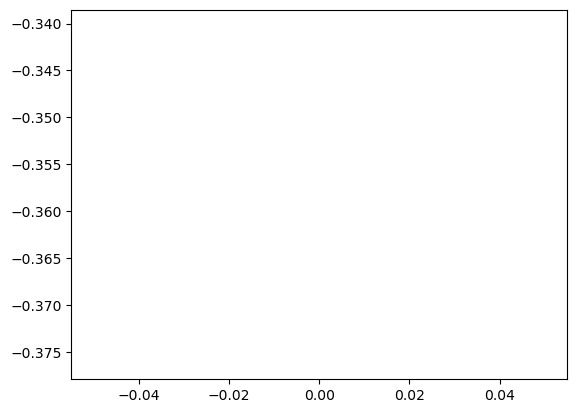

[0.01094663 0.00566117 0.15219146 0.06899709 0.05961408 0.02030613
 0.92834964 0.32576993]
0.0019932383172931714
(-0.46613251063906563+0j)
[0.01095011 0.00566822 0.15222404 0.06909004 0.05961252 0.02032884
 0.92821319 0.32612228]
0.0020461710787310137
(-0.3909697794445636+0j)
[0.01095437 0.00567581 0.15225908 0.06918639 0.05961404 0.02035321
 0.92807228 0.32648424]
0.0019108591764627372
(-0.5516450454348899+0j)
[0.01095875 0.00568309 0.15229209 0.06927661 0.05961767 0.0203766
 0.92794074 0.32682102]
0.001955827435971948
(-0.48798335852498326+0j)
[0.01096372 0.00569073 0.15233266 0.06937134 0.05962131 0.02040033
 0.92780581 0.3271625 ]
0.0019608986035833335
(-0.6535921809695147+0j)
Epoch 5, Hamiltonian Expectation Value: (-0.6535921809695147+0j)


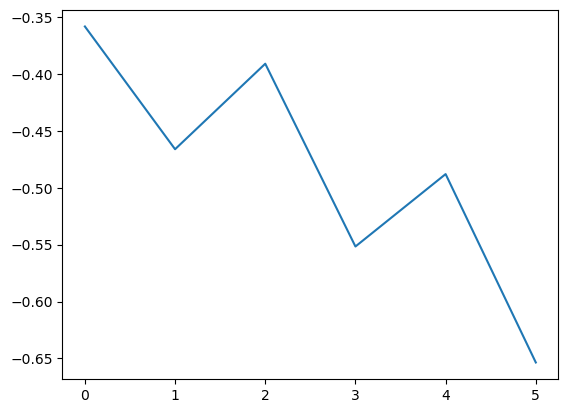

[0.01096891 0.00569848 0.1523782  0.06946798 0.05962419 0.02042373
 0.9276704  0.32750229]
0.0020240156469180947
(-0.6338272253408056+0j)
[0.01097472 0.00570675 0.1524202  0.06956625 0.05963163 0.02044951
 0.92753044 0.32785482]
0.001758925123879776
(-0.608035357087825+0j)
[0.01097931 0.00571371 0.15245693 0.06965189 0.05963544 0.02047113
 0.92740824 0.32816279]
0.0016314892909874267
(-0.6003373516804409+0j)
[0.01098167 0.00571936 0.15247233 0.06972471 0.05963582 0.02049071
 0.92729536 0.32845754]
0.0021169329230102934
(-0.61796909049767+0j)
[0.01098644 0.00572744 0.15250972 0.06982569 0.05963883 0.02051651
 0.92714776 0.32883274]
0.0018657031887912025
(-0.6940302070975903+0j)
Epoch 10, Hamiltonian Expectation Value: (-0.6940302070975903+0j)


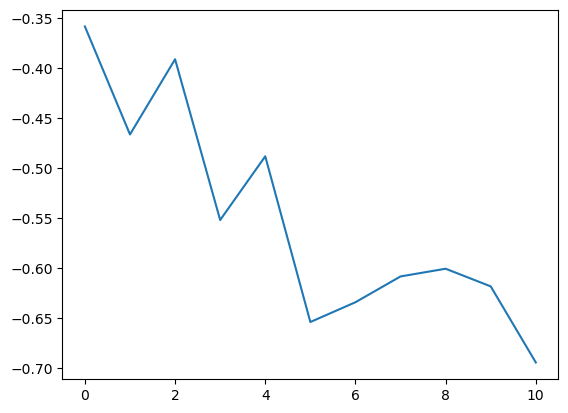

[0.01099053 0.00573454 0.15253805 0.06991319 0.05964264 0.02053975
 0.92701776 0.32916493]
0.0018557063059499457
(-0.5122578364718007+0j)
[0.01099681 0.00574253 0.152585   0.07000649 0.05965135 0.02056376
 0.92688845 0.32948393]
0.0020678064369817816
(-0.562748043379234+0j)
[0.011002   0.00575069 0.15262749 0.07010752 0.0596548  0.02058903
 0.92674349 0.3298478 ]
0.0019159159781964017
(-0.533337556999294+0j)
[0.01100829 0.0057588  0.15268655 0.07020735 0.0596585  0.02061182
 0.92660973 0.33017241]
0.0019518019012362106
(-0.5108090714867916+0j)
[0.01101333 0.00576659 0.15272197 0.07030139 0.05966433 0.02063663
 0.92647262 0.3305177 ]
0.0015712704074542136
(-0.5218541744625345+0j)
Epoch 15, Hamiltonian Expectation Value: (-0.5218541744625345+0j)


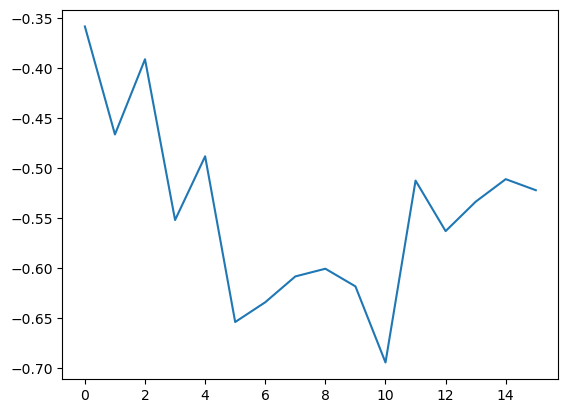

[0.01101856 0.00577334 0.15276423 0.07038163 0.05967014 0.02065648
 0.92636226 0.33078773]
0.002027740874309462
(-0.5426677300383531+0j)
[0.01102187 0.00578058 0.15279061 0.07047571 0.0596696  0.02068057
 0.92621935 0.33115385]
0.0019832697465902343
(-0.5641952678717994+0j)
[0.01102797 0.00578896 0.15282574 0.07057096 0.05968138 0.02070753
 0.92608037 0.33150172]
0.0020877210623424006
(-0.5013353384159057+0j)
[0.01103447 0.00579783 0.1528661  0.07067265 0.05969278 0.02073563
 0.92593322 0.33186811]
0.0017496775551000953
(-0.543342306218515+0j)
[0.01104011 0.00580539 0.15289987 0.07075786 0.05970333 0.02075955
 0.92580982 0.33217479]
0.0016435918285514187
(-0.5359528178674103+0j)
Epoch 20, Hamiltonian Expectation Value: (-0.5359528178674103+0j)


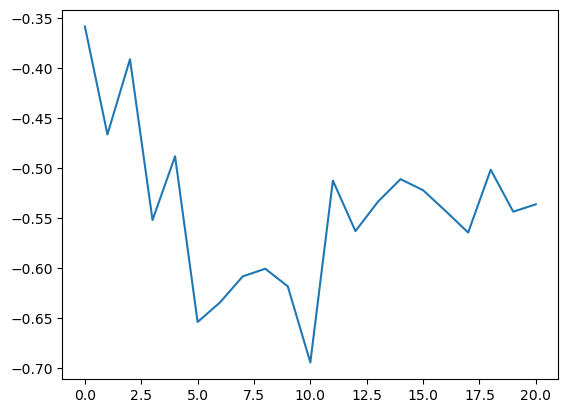

[0.01104384 0.00581177 0.15292552 0.07083619 0.05970693 0.02078034
 0.92569291 0.3324698 ]
0.0018752783977658248
(-0.441917670865266+0j)
[0.01104774 0.00581893 0.15294252 0.07092099 0.05971395 0.02080514
 0.92556085 0.33280835]
0.0020682827200036707
(-0.6229835841181399+0j)
[0.01105322 0.00582735 0.15297657 0.07102033 0.05972213 0.02083241
 0.92541366 0.33317712]
0.0021608107998862813
(-0.4392189089283895+0j)
[0.01105729 0.00583539 0.15300361 0.07112116 0.05972482 0.02085926
 0.92525981 0.33356781]
0.002017961389789469
(-0.6220816579511418+0j)
[0.01106202 0.00584335 0.15302833 0.07121524 0.05973269 0.02088607
 0.92511601 0.33393165]
0.001893635597663694
(-0.6623911038885569+0j)
Epoch 25, Hamiltonian Expectation Value: (-0.6623911038885569+0j)


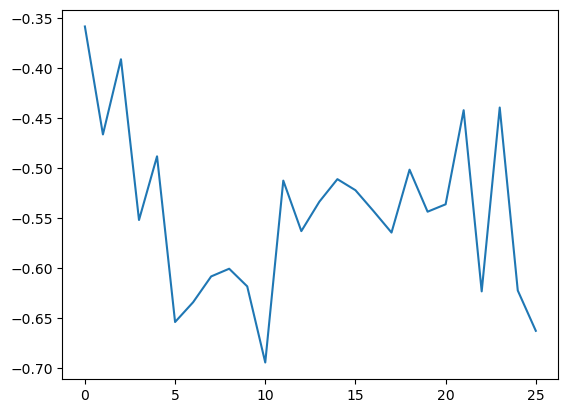

[0.01106799 0.00585139 0.15308236 0.07131399 0.05973638 0.020909
 0.92498107 0.33425704]
0.0018316701746294592
(-0.4434823787503935+0j)
[0.01107345 0.00585912 0.15312224 0.07140577 0.05974308 0.02093277
 0.92484957 0.33457988]
0.001882116603640105
(-0.5444383133018863+0j)
[0.0110797  0.00586739 0.15316335 0.07149995 0.05975327 0.02095826
 0.92471478 0.33490959]
0.002008755703115444
(-0.6557930297421511+0j)
[0.01108518 0.00587559 0.15321457 0.07160319 0.05975478 0.02098222
 0.92457028 0.33526078]
0.0018303216037897385
(-0.646535530995844+0j)
[0.01109023 0.00588319 0.15324808 0.0716931  0.05976156 0.02100634
 0.92443805 0.3355877 ]
0.001758108227623137
(-0.469811649137009+0j)
Epoch 30, Hamiltonian Expectation Value: (-0.469811649137009+0j)


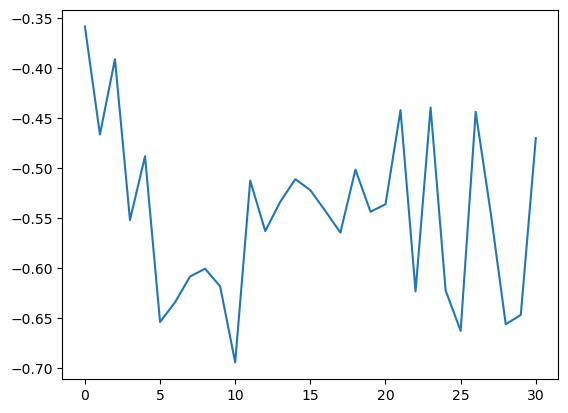

[0.01109565 0.00589075 0.15328101 0.07177959 0.05977098 0.02103024
 0.92431173 0.3358985 ]
0.0018351439327664205
(-0.5767781753449812+0j)
[0.01110075 0.00589834 0.1533238  0.07187303 0.05977435 0.021053
 0.92417885 0.33622212]
0.002080842050684085
(-0.5980714660121685+0j)
[0.01110551 0.0059065  0.15336477 0.07197652 0.05977545 0.02107823
 0.92402779 0.3365942 ]
0.0018672860323502728
(-0.6035301042135703+0j)
[0.01110989 0.00591392 0.15339768 0.07206826 0.05977851 0.02110172
 0.92389187 0.33693022]
0.0017317365547717318
(-0.46424920041823287+0j)
[0.01111524 0.00592137 0.15343818 0.07215678 0.05978452 0.02112415
 0.92376598 0.33723509]
0.002049724572057581
(-0.49484069682405474+0j)
Epoch 35, Hamiltonian Expectation Value: (-0.49484069682405474+0j)


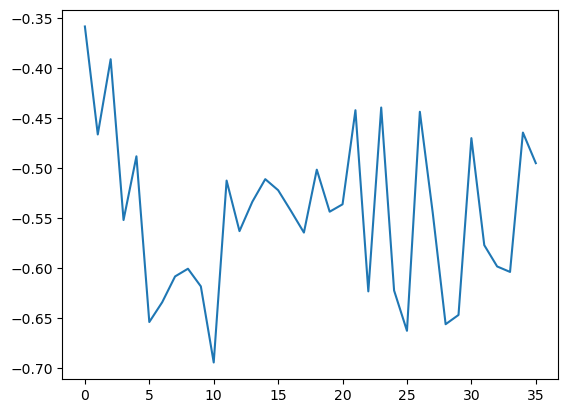

[0.0111192  0.00592917 0.15346362 0.07225383 0.05978734 0.02115013
 0.92361661 0.33760926]
0.0024443045664312556
(-0.36843936349882156+0j)
[0.01112239 0.00593775 0.15348587 0.07236639 0.05978546 0.0211796
 0.92343864 0.33805981]
0.0019214337882067615
(-0.6854484546155404+0j)
[0.01112774 0.00594579 0.15352312 0.07246239 0.05979191 0.02120473
 0.9232982  0.33840272]
0.0018553223977241587
(-0.7033922796625091+0j)
[0.01113182 0.00595305 0.1535604  0.07255558 0.05979154 0.02122695
 0.9231618  0.3387362 ]
0.0020790442850998425
(-0.6485037619010293+0j)
[0.01113595 0.00596101 0.15359479 0.07265756 0.05979149 0.02125222
 0.92300884 0.33911352]
0.0021621958793079077
(-0.6378985166656258+0j)
Epoch 40, Hamiltonian Expectation Value: (-0.6378985166656258+0j)


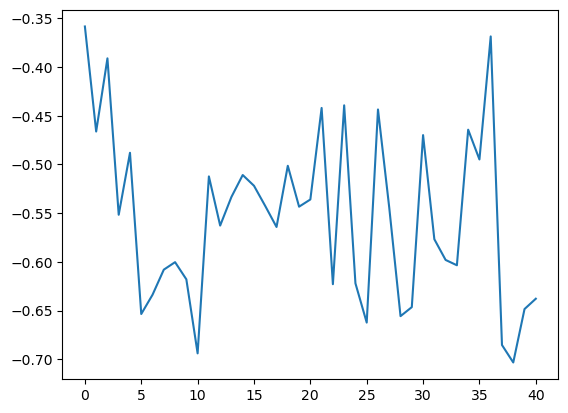

[0.01114204 0.00597016 0.15362854 0.07276295 0.05980225 0.02128192
 0.92285039 0.33950253]
0.0019481541496574532
(-0.463635510806608+0j)
[0.01114596 0.00597771 0.15365416 0.07285649 0.05980507 0.02130683
 0.92270648 0.3398595 ]
0.0021672259861886065
(-0.5651722776560484+0j)
[0.01115054 0.00598624 0.15367521 0.07295779 0.05981245 0.02133602
 0.92254699 0.34025758]
0.0018067610629888048
(-0.7600817307705607+0j)
[0.01115372 0.00599305 0.15369551 0.07304341 0.05981384 0.02135887
 0.92241318 0.34059075]
0.002282003033791813
(-0.7442065496227056+0j)
[0.01115718 0.00600133 0.15372616 0.07315324 0.05981063 0.02138589
 0.92224404 0.34100973]
0.0021303349679803055
(-0.6221699557648289+0j)
Epoch 45, Hamiltonian Expectation Value: (-0.6221699557648289+0j)


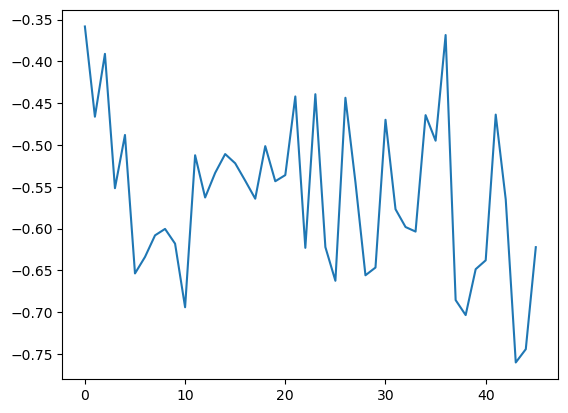

[0.01116384 0.00601063 0.15377747 0.07326408 0.05981759 0.02141352
 0.92208643 0.34138547]
0.0018909269998248956
(-0.6104240790710822+0j)
[0.01116861 0.00601845 0.15380647 0.07335695 0.05982393 0.02143883
 0.92194562 0.3417296 ]
0.0017572798529044333
(-0.7483342286034357+0j)
[0.01117331 0.00602579 0.15384406 0.07344712 0.05982708 0.02146113
 0.92181437 0.34204499]
0.002079030268828346
(-0.6596351346018517+0j)
[0.01117745 0.00603391 0.15386368 0.07354486 0.05983277 0.02148894
 0.9216594  0.34242954]
0.0020742524586408353
(-0.6419201370356562+0j)
[0.01118111 0.00604176 0.15388944 0.07364477 0.05983337 0.02151483
 0.92150426 0.34281183]
0.001920878004153667
(-0.3760273725833345+0j)
Epoch 50, Hamiltonian Expectation Value: (-0.3760273725833345+0j)


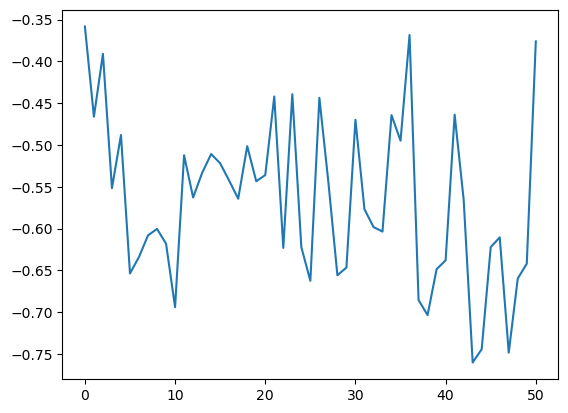

[0.01118577 0.00604965 0.1539177  0.07373916 0.05983919 0.02154049
 0.92136003 0.34316342]
0.0019433685602798913
(-0.5246694041358443+0j)
[0.0111904  0.0060575  0.15396142 0.07383994 0.05983856 0.02156382
 0.92121393 0.34351255]
0.0023144483507397764
(-0.6092648703220296+0j)
[0.01119754 0.00606764 0.15401654 0.07396126 0.05984563 0.02159401
 0.92104008 0.34392413]
0.002176947297457252
(-0.5664100797053326+0j)
[0.01120246 0.0060765  0.15404467 0.07406722 0.05985158 0.02162319
 0.92087573 0.34432539]
0.001939298472070224
(-0.6979084945897099+0j)
[0.01120711 0.00608434 0.15409292 0.07416958 0.05984931 0.02164579
 0.92072942 0.34467154]
0.0017349626801010868
(-0.503214740768921+0j)
Epoch 55, Hamiltonian Expectation Value: (-0.503214740768921+0j)


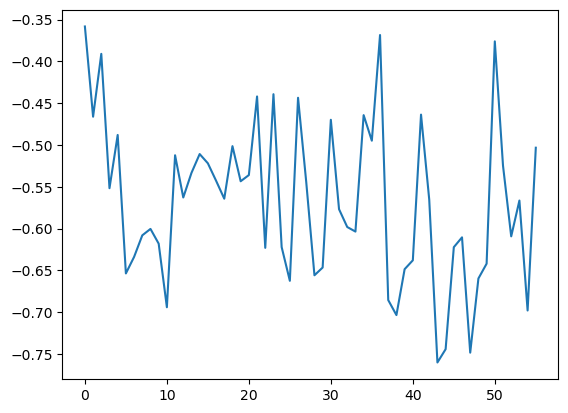

[0.01121075 0.00609123 0.15411611 0.07425452 0.05985217 0.02166836
 0.92059798 0.34499169]
0.0017798123736615609
(-0.6412472871243506+0j)
[0.01121432 0.00609818 0.15415104 0.07434558 0.05984978 0.02168951
 0.92046246 0.34531677]
0.001935415772188981
(-0.7488749494779982+0j)
[0.01122019 0.0061067  0.15419321 0.07444635 0.05985651 0.02171535
 0.92031551 0.3456646 ]
0.002219376601664344
(-0.5542543466504869+0j)
[0.01122611 0.00611613 0.15423599 0.07456005 0.05986188 0.02174443
 0.92014681 0.34606677]
0.001925121868488716
(-0.8437593518499428+0j)
[0.01123052 0.00612393 0.15427622 0.07465988 0.05986128 0.02176793
 0.91999967 0.34641668]
0.0022436608278179333
(-0.7280333215469261+0j)
Epoch 60, Hamiltonian Expectation Value: (-0.7280333215469261+0j)


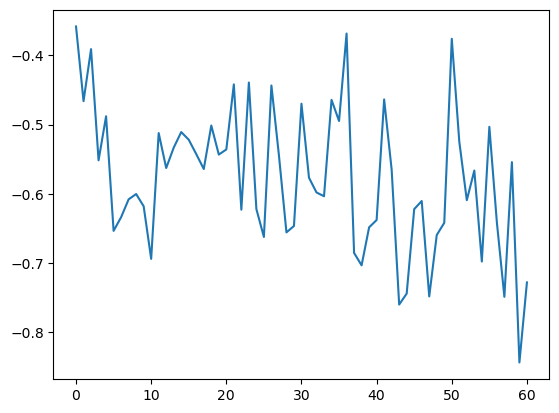

[0.01123568 0.00613315 0.15430453 0.07476979 0.059868   0.02179836
 0.91982817 0.34683213]
0.0016250759793404468
(-0.6079234906849282+0j)
[0.01123879 0.00613951 0.15432515 0.0748495  0.05986939 0.02181922
 0.91970378 0.34713374]
0.0021919816020622915
(-0.6456483001815967+0j)
[0.01124449 0.0061488  0.15436477 0.07496155 0.05987481 0.02184825
 0.91953553 0.34753432]
0.0020358769013275055
(-0.5975547261731784+0j)
[0.01124935 0.00615728 0.15439329 0.07506255 0.05988071 0.02187571
 0.91937971 0.34790886]
0.002122867793708281
(-0.6101852012746748+0j)
[0.01125457 0.00616616 0.15442709 0.07516964 0.05988609 0.02190397
 0.9192165  0.34829875]
0.0017019972147645792
(-0.6545487535611202+0j)
Epoch 65, Hamiltonian Expectation Value: (-0.6545487535611202+0j)


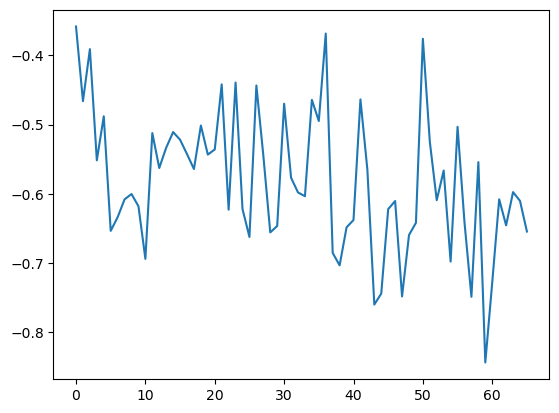

[0.01125941 0.00617357 0.15446248 0.0752586  0.05989071 0.02192652
 0.91908523 0.3486076 ]
0.002101148702346885
(-0.6309596067240546+0j)
[0.01126509 0.00618266 0.15449667 0.07536508 0.05989846 0.02195546
 0.91892311 0.34899314]
0.0017400782678718158
(-0.5182894824211355+0j)
[0.01126769 0.00618918 0.15451425 0.07544925 0.05989755 0.02197732
 0.91878836 0.34932037]
0.0022163002303934166
(-0.634488469358721+0j)
[0.01127217 0.00619805 0.1545421  0.07555885 0.05990066 0.02200642
 0.91861646 0.34973354]
0.002055277421674287
(-0.6030110078323949+0j)
[0.01127729 0.00620677 0.15456219 0.07565809 0.05991107 0.02203598
 0.91845793 0.35011539]
0.0024379073804743816
(-0.6380222823823264+0j)
Epoch 70, Hamiltonian Expectation Value: (-0.6380222823823264+0j)


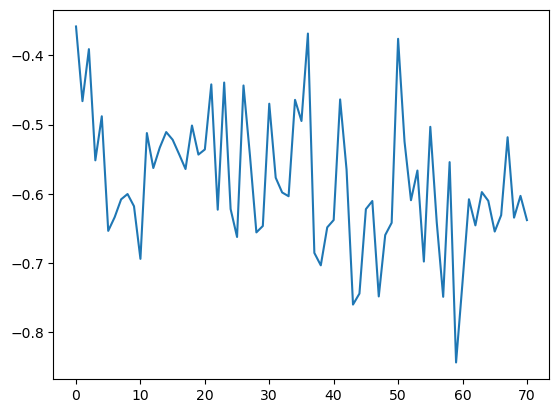

[0.01128264 0.00621677 0.15459592 0.07578018 0.05991549 0.02206838
 0.91826786 0.35056923]
0.0017553572490500513
(-0.6216770961845667+0j)
[0.01128684 0.00622413 0.1546258  0.07587029 0.05991827 0.02209146
 0.91813053 0.35089391]
0.0023821878226476024
(-0.5387099544907565+0j)
[0.0112923  0.006234   0.15466473 0.07599206 0.05992145 0.02212254
 0.9179444  0.35133423]
0.0020554202099976856
(-0.6516075545687032+0j)
[0.01129648 0.00624232 0.15469214 0.076095   0.05992365 0.02214952
 0.91778311 0.35171868]
0.0023658669699196683
(-0.6626503671471027+0j)
[0.0113005  0.00625147 0.15472121 0.07621256 0.05992281 0.02217945
 0.91759725 0.35216306]
0.002028206741385436
(-0.6248506070974899+0j)
Epoch 75, Hamiltonian Expectation Value: (-0.6248506070974899+0j)


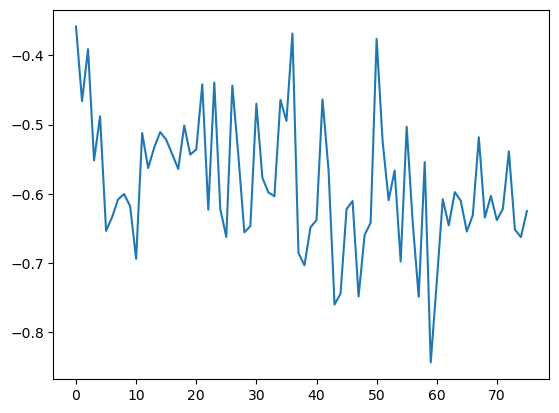

[0.01130381 0.00625926 0.15474674 0.07631366 0.05992108 0.0222048
 0.9174375  0.35254442]
0.0023986298336651267
(-0.6837725000048507+0j)
[0.01130672 0.00626804 0.15476126 0.07642717 0.05991978 0.02223545
 0.91724894 0.35300184]
0.0021674829707093446
(-0.7836404967194063+0j)
[0.01131232 0.00627734 0.15480616 0.07654217 0.05992216 0.02226344
 0.91707761 0.35339963]
0.002046312354627917
(-0.6495902409495127+0j)
[0.01131703 0.00628589 0.15484101 0.07664816 0.05992425 0.0222901
 0.91691556 0.35377933]
0.002367950192904478
(-0.6719815340333988+0j)
[0.01132125 0.00629526 0.1548637  0.07676421 0.05992691 0.02232157
 0.91672808 0.35422708]
0.002206782444812695
(-0.7105288475859617+0j)
Epoch 80, Hamiltonian Expectation Value: (-0.7105288475859617+0j)


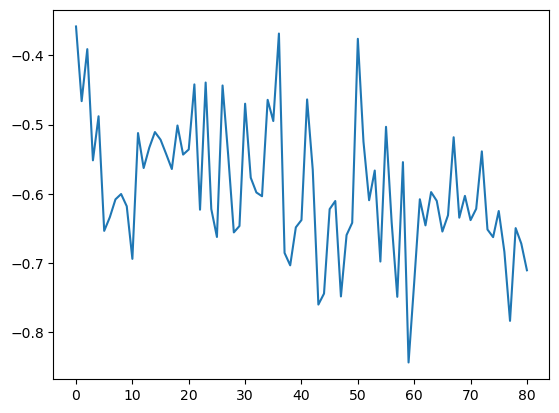

[0.01132468 0.00630367 0.15489361 0.07687561 0.05992309 0.02234852
 0.9165528  0.35464188]
0.0022417510723166645
(-0.7108009924316843+0j)
[0.01132927 0.00631283 0.15492628 0.07699017 0.0599243  0.02237772
 0.91637376 0.35506283]
0.0022520545541767373
(-0.7142238334649889+0j)
[0.01133295 0.00632155 0.15495554 0.07710383 0.05992187 0.02240588
 0.91619385 0.35548776]
0.002266818793911101
(-0.6919716829853946+0j)
[0.01133757 0.00633085 0.15498341 0.07721802 0.05992492 0.02243624
 0.91601239 0.35591546]
0.0021655653930995797
(-0.7376775328281222+0j)
[0.01134143 0.00633938 0.15501951 0.07733051 0.05992117 0.02246261
 0.91583881 0.3563205 ]
0.002247002222057203
(-0.7149867694508601+0j)
Epoch 85, Hamiltonian Expectation Value: (-0.7149867694508601+0j)


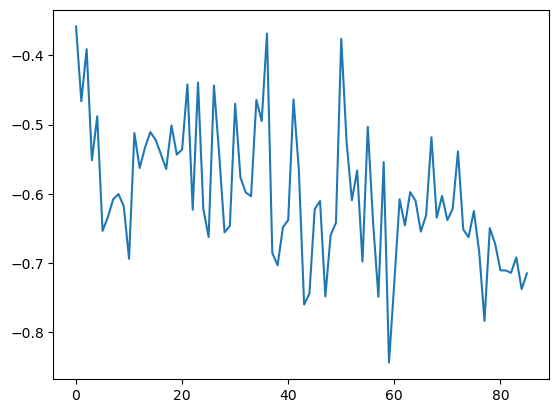

[0.01134685 0.00634895 0.15506144 0.07744937 0.05992311 0.02249187
 0.91565823 0.35673775]
0.002146334852659998
(-0.7672594181845116+0j)
[0.01135364 0.00635884 0.15511186 0.07756664 0.05992974 0.02252097
 0.91548637 0.35712788]
0.0019541190016228896
(-0.7465637697959148+0j)
[0.01135776 0.00636684 0.15515262 0.07767156 0.0599265  0.02254464
 0.91532878 0.35748991]
0.002216474900495884
(-0.5486830919085093+0j)
[0.01136378 0.00637673 0.15517913 0.07778332 0.05993786 0.02257722
 0.91515074 0.35790535]
0.0021379377644821372
(-0.5415231169659134+0j)
[0.01136717 0.00638506 0.15520424 0.07789126 0.05993577 0.02260437
 0.91497753 0.35831199]
0.0020647193049781886
(-0.6809531010443071+0j)
Epoch 90, Hamiltonian Expectation Value: (-0.6809531010443071+0j)


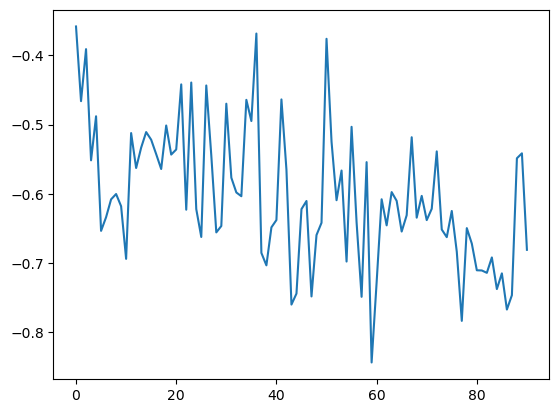

[0.01137373 0.00639464 0.15525195 0.07800435 0.05994251 0.02263263
 0.91481102 0.35868839]
0.0020785738832290726
(-0.5726365086208123+0j)
[0.01137848 0.0064035  0.15527587 0.07810952 0.05994859 0.02266181
 0.91464228 0.35908209]
0.0023384101535030635
(-0.5043280004642717+0j)
[0.0113848  0.00641399 0.15530552 0.0782287  0.05995951 0.02269601
 0.91445279 0.35952128]
0.0020231668546914243
(-0.7438838011833158+0j)
[0.01139038 0.00642306 0.15534394 0.0783371  0.05996458 0.02272373
 0.91428782 0.35989752]
0.0019592847911247572
(-0.5875724436604547+0j)
[0.01139429 0.00643115 0.15537325 0.07843915 0.05996438 0.02274917
 0.91412749 0.36026789]
0.0023244985109820634
(-0.8517595784907914+0j)
Epoch 95, Hamiltonian Expectation Value: (-0.8517595784907914+0j)


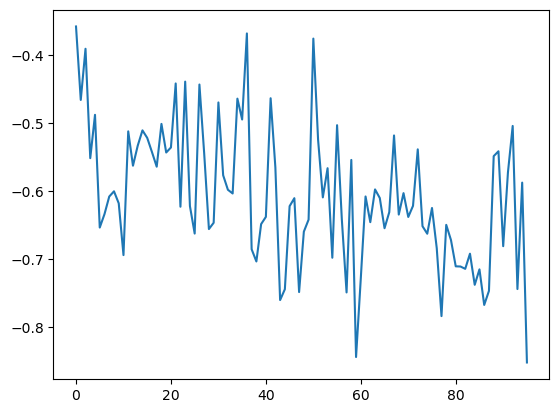

[0.01139817 0.00644041 0.1553993  0.07855706 0.05996341 0.02277947
 0.9139367  0.36071268]
0.0019338063061867233
(-0.6515896967151454+0j)
[0.01140365 0.00644918 0.15543677 0.07866133 0.05996868 0.02280616
 0.91377822 0.36107226]
0.002378291699034843
(-0.785819646740363+0j)
[0.01140887 0.00645915 0.15548537 0.07879042 0.05996593 0.02283568
 0.91358299 0.36151519]
0.0023369440064133417
(-0.8098655404286372+0j)
[0.01141447 0.00646928 0.15552513 0.07891483 0.05996872 0.02286703
 0.91339006 0.36195537]
0.0024066837046203215
(-0.7578953044235229+0j)
[0.01141802 0.00647862 0.15555595 0.07903881 0.05996366 0.02289687
 0.91319121 0.3624152 ]
0.00200155013905429
(-0.7597869276337402+0j)
Epoch 100, Hamiltonian Expectation Value: (-0.7597869276337402+0j)


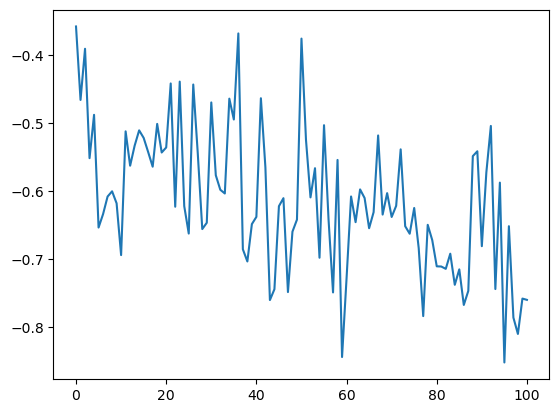

[0.01142271 0.00648728 0.15558623 0.07914419 0.05996694 0.02292417
 0.91302568 0.36279348]
0.0022252097904662733
(-0.6345546270319162+0j)
[0.01142848 0.0064972  0.15562391 0.07926302 0.05997199 0.02295493
 0.91284123 0.36321217]
0.0021250718457603473
(-0.6329134002362984+0j)
[0.01143217 0.00650577 0.15565272 0.07937374 0.05996977 0.02298212
 0.91266463 0.36361758]
0.0023237925977913814
(-0.6318153242177148+0j)
[0.01143639 0.00651529 0.15567955 0.07949328 0.05997018 0.02301304
 0.91247109 0.36406312]
0.002380069293348613
(-0.7534370251886007+0j)
[0.01143965 0.00652443 0.15571024 0.07961661 0.05996358 0.02304205
 0.91227293 0.36451833]
0.0019565186478132687
(-0.5540892630244451+0j)
Epoch 105, Hamiltonian Expectation Value: (-0.5540892630244451+0j)


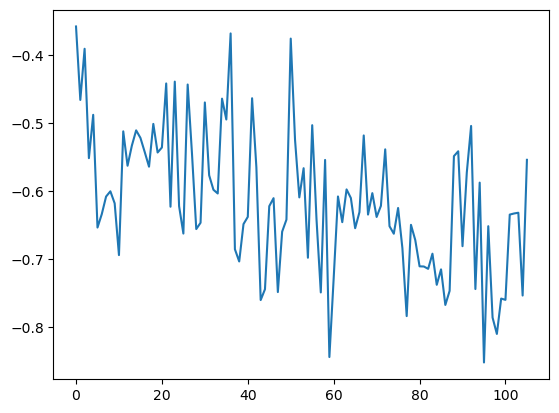

[0.01144348 0.0065326  0.15573403 0.07971811 0.05996477 0.0230685
 0.91210883 0.36489431]
0.00203832516657768
(-0.6441750163704477+0j)
[0.01144713 0.00654094 0.15575989 0.07982431 0.05996379 0.02309524
 0.91193756 0.36528612]
0.001986652393032603
(-0.6331747115296881+0j)
[0.01145249 0.00654997 0.15579126 0.07993031 0.05997016 0.02312358
 0.91177115 0.36566161]
0.0022999267836316013
(-0.8693521693254785+0j)
[0.01145736 0.00655974 0.15583154 0.0800546  0.05996865 0.02315329
 0.91157755 0.36609772]
0.0016939457693812884
(-0.7659125315444371+0j)
[0.01146133 0.00656714 0.15586235 0.08014682 0.05996919 0.02317573
 0.9114347  0.36641821]
0.0024041734323988445
(-0.7642251739566074+0j)
Epoch 110, Hamiltonian Expectation Value: (-0.7642251739566074+0j)


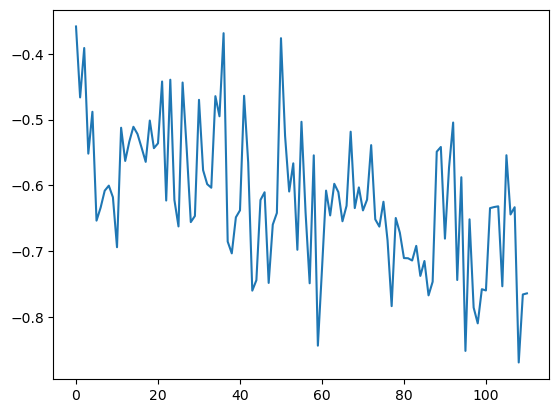

[0.01146644 0.00657737 0.15590468 0.08027724 0.05996764 0.02320682
 0.91123159 0.36687447]
0.00234909259441388
(-0.7918936489767834+0j)
[0.01147209 0.00658781 0.15593696 0.08040133 0.05997312 0.02323999
 0.91103328 0.36732245]
0.002225764736207147
(-0.713853572213891+0j)
[0.01147686 0.00659733 0.15597162 0.08052071 0.05997367 0.02326955
 0.91084498 0.36774601]
0.0022519157793201958
(-0.6628902056455566+0j)
[0.01148086 0.00660661 0.15599645 0.08063765 0.05997366 0.02329973
 0.91065361 0.36818135]
0.0020261078063699926
(-0.7586210755811444+0j)
[0.01148376 0.00661465 0.15600799 0.0807385  0.05997413 0.02332736
 0.91048154 0.36857764]
0.002235732911686502
(-0.7961991140892151+0j)
Epoch 115, Hamiltonian Expectation Value: (-0.7961991140892151+0j)


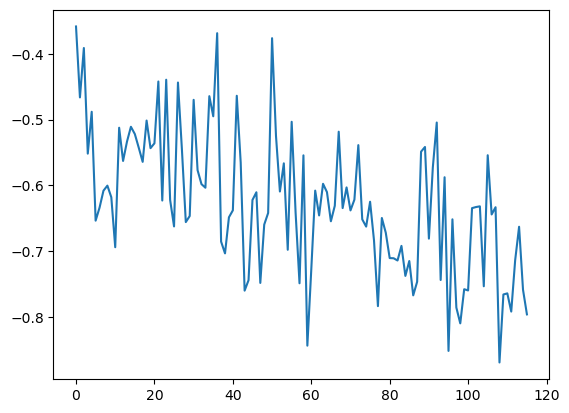

[0.01148792 0.00662395 0.156039   0.08085737 0.05997264 0.02335663
 0.91029089 0.36900721]
0.001979462005558148
(-0.5854621157725591+0j)
[0.01149244 0.0066326  0.15607429 0.08096588 0.05997264 0.02338287
 0.91012145 0.36938427]
0.002151790086966141
(-0.7942816225500061+0j)
[0.01149877 0.00664265 0.15613079 0.08109036 0.05997323 0.02341088
 0.90993821 0.36978208]
0.00225919720083395
(-0.9107372232395704+0j)
[0.01150328 0.00665219 0.15617051 0.0812141  0.05997    0.02343966
 0.90974449 0.37021292]
0.0023716061948607257
(-0.5537070831701981+0j)
[0.01150913 0.00666276 0.15622163 0.08134787 0.05996879 0.02347043
 0.9095406  0.37066056]
0.00231400356412913
(-0.8246096940530722+0j)
Epoch 120, Hamiltonian Expectation Value: (-0.8246096940530722+0j)


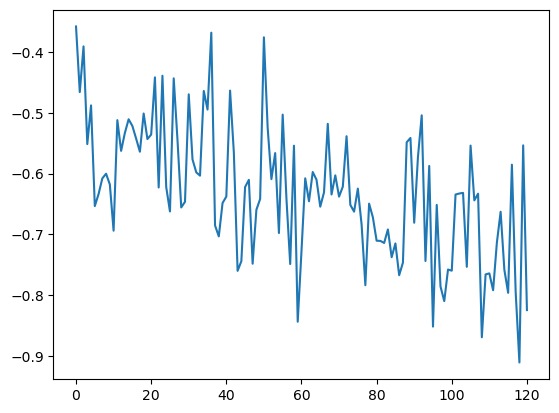

[0.01151332 0.00667235 0.15625609 0.08147252 0.05996555 0.02350009
 0.90934186 0.37110436]
0.0019840823411514993
(-0.8477208193102486+0j)
[0.01151845 0.0066814  0.1562891  0.08158115 0.05996961 0.023528
 0.90917069 0.37148303]
0.0024405500583895992
(-0.618424745291752+0j)
[0.01152306 0.00669173 0.15631597 0.08170945 0.05997084 0.02356145
 0.90895989 0.37195645]
0.002067231029635105
(-0.7692845730655551+0j)
[0.01152688 0.00670047 0.156331   0.08181507 0.05997434 0.0235909
 0.90878118 0.37236066]
0.001996206864143579
(-0.659989962201421+0j)
[0.01153211 0.00670964 0.15636518 0.08192515 0.05997834 0.02361899
 0.90860806 0.37274163]
0.002399739390127994
(-0.8918600817737953+0j)
Epoch 125, Hamiltonian Expectation Value: (-0.8918600817737953+0j)


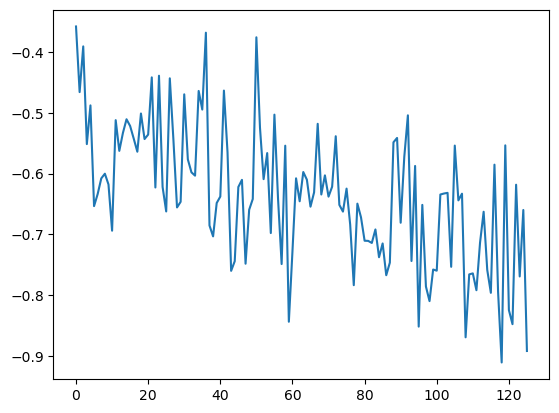

[0.01153676 0.00671988 0.15639352 0.0820526  0.0599793  0.02365184
 0.9083994  0.37320743]
0.0023380439298114897
(-0.5881347270927442+0j)
[0.01154193 0.00673019 0.15642729 0.0821795  0.05998115 0.0236841
 0.90819531 0.37365911]
0.0022376229781126216
(-0.6985799235887441+0j)
[0.01154759 0.00674041 0.15646499 0.08230316 0.05998466 0.02371538
 0.90800013 0.37408728]
0.0021508912851781743
(-0.6763048302062812+0j)
[0.01155148 0.00674955 0.15648344 0.08241506 0.0599865  0.02374565
 0.90781171 0.37450949]
0.001984349216181987
(-0.5968097913557482+0j)
[0.01155776 0.00675924 0.15652357 0.08252738 0.05999378 0.02377462
 0.90763864 0.37488392]
0.0020958352138950617
(-0.8030392175931915+0j)
Epoch 130, Hamiltonian Expectation Value: (-0.8030392175931915+0j)


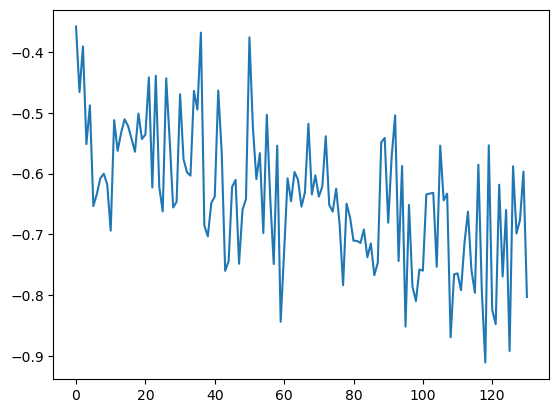

[0.01156271 0.00676857 0.15656993 0.08264763 0.05999074 0.02380134
 0.90745488 0.37528117]
0.0021358466602021692
(-0.7215547495906671+0j)
[0.01156712 0.00677785 0.15660492 0.08276584 0.05998902 0.0238296
 0.90726664 0.3756936 ]
0.0019877664424414227
(-0.8724230478544724+0j)
[0.01157137 0.00678664 0.1566261  0.08287149 0.05999259 0.02385812
 0.90709145 0.37608165]
0.0021313633729440284
(-0.7918528974816667+0j)
[0.01157404 0.00679502 0.15665017 0.08298493 0.05998579 0.02388479
 0.90690343 0.376499  ]
0.0020484500212510875
(-0.7737157215447099+0j)
[0.01157943 0.00680459 0.15668601 0.0830996  0.05998932 0.02391377
 0.90672234 0.37689199]
0.002174181776466355
(-0.6307101832984486+0j)
Epoch 135, Hamiltonian Expectation Value: (-0.6307101832984486+0j)


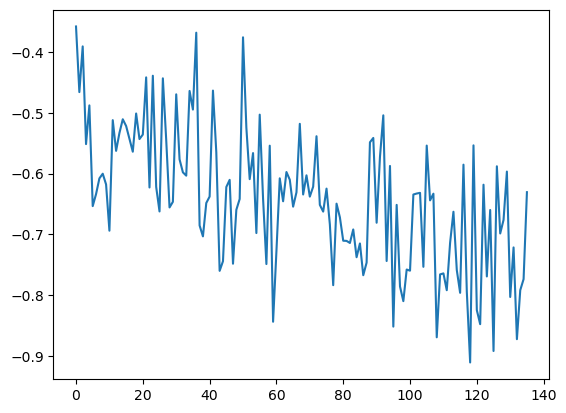

[0.01158307 0.00681363 0.15671864 0.08321909 0.05998404 0.02394143
 0.90652951 0.37731449]
0.002670388616470261
(-0.8740924570536732+0j)
[0.01158766 0.00682491 0.15674761 0.08336193 0.05998244 0.02397769
 0.9062919  0.37783897]
0.002294669381271647
(-0.7106398530751047+0j)
[0.01159337 0.00683553 0.15677751 0.08348689 0.05998854 0.02401134
 0.90608793 0.37828444]
0.0023557201248055005
(-0.7857070889457088+0j)
[0.01159929 0.00684646 0.15680526 0.08361398 0.0599963  0.02404641
 0.90587893 0.37874131]
0.002250114980912231
(-0.7736207449906105+0j)
[0.01160569 0.00685719 0.15685564 0.08374507 0.05999833 0.02407729
 0.90567831 0.37916835]
0.0023115365511629316
(-0.6947486260087828+0j)
Epoch 140, Hamiltonian Expectation Value: (-0.6947486260087828+0j)


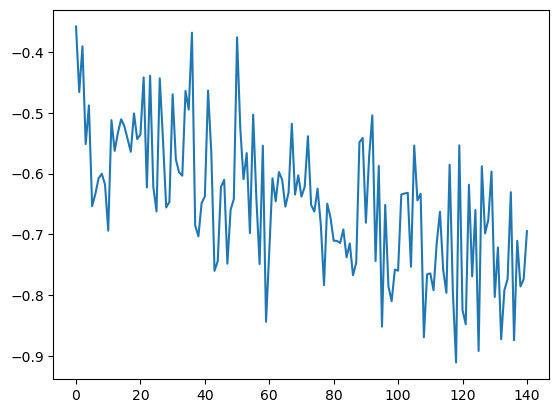

[0.01161073 0.00686757 0.15687909 0.08386876 0.06000312 0.024111
 0.90547155 0.3796216 ]
0.0023695124315309115
(-0.6283057011166456+0j)
[0.01161572 0.00687818 0.15689858 0.08399379 0.06000883 0.02414613
 0.90525914 0.38008873]
0.0023862073935108606
(-0.848223617852973+0j)
[0.01161862 0.00688769 0.15691588 0.08411863 0.06000417 0.02417768
 0.90504482 0.38056254]
0.0022045780189032128
(-0.8604677182661223+0j)
[0.01162305 0.00689747 0.15693371 0.08423521 0.06000837 0.02421008
 0.90484601 0.38099886]
0.002441325391343575
(-0.7059037003065315+0j)
[0.01162746 0.00690797 0.15696244 0.08436819 0.06000691 0.02424337
 0.9046254  0.38147897]
0.002077158032869928
(-0.7481879687438935+0j)
Epoch 145, Hamiltonian Expectation Value: (-0.7481879687438935+0j)


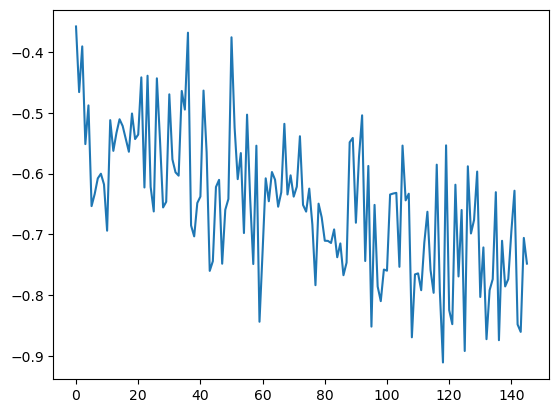

[0.01163107 0.00691685 0.15699056 0.08448293 0.06000341 0.0242709
 0.90443684 0.3818874 ]
0.002179002380567538
(-0.8997359496074102+0j)
[0.01163694 0.00692725 0.15702371 0.08460497 0.0600094  0.02430308
 0.90423967 0.38231009]
0.0022928195470007357
(-0.9064321074552837+0j)
[0.0116426  0.00693789 0.15706668 0.08473677 0.0600098  0.02433451
 0.90403192 0.38275187]
0.0019807012026971218
(-0.8525629968985953+0j)
[0.01164634 0.00694661 0.1570804  0.08484122 0.06001303 0.02436363
 0.90385167 0.38314596]
0.002460897464696222
(-0.7853983346423123+0j)
[0.01165186 0.00695787 0.15711469 0.08497852 0.06001494 0.02439864
 0.90362663 0.38362909]
0.0021356352577249385
(-0.8805853477081229+0j)
Epoch 150, Hamiltonian Expectation Value: (-0.8805853477081229+0j)


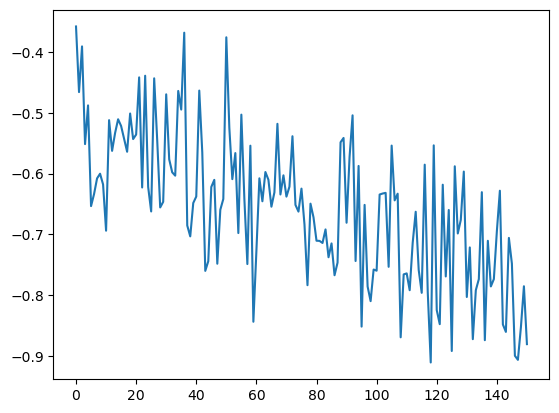

[0.01165577 0.00696716 0.15714305 0.08509714 0.06001242 0.02442753
 0.90343073 0.3840506 ]
0.0021363557049094203
(-0.7926043419088927+0j)
[0.01165941 0.00697629 0.15717136 0.08521578 0.0600085  0.02445581
 0.90323502 0.38447136]
0.002385007159474646
(-0.7602133215239303+0j)
[0.01166214 0.00698587 0.15718605 0.08534119 0.0600035  0.0244878
 0.90301604 0.3849501 ]
0.0021961361084887124
(-0.806267091488926+0j)
[0.01166758 0.00699622 0.15721679 0.08546433 0.06000781 0.02451999
 0.90281431 0.38538008]
0.0019555819254425816
(-0.800162294132265+0j)
[0.01167201 0.00700526 0.15723629 0.08557081 0.06001246 0.02454925
 0.90263431 0.38576705]
0.0024760547124106505
(-0.8189551547125511+0j)
Epoch 155, Hamiltonian Expectation Value: (-0.8189551547125511+0j)


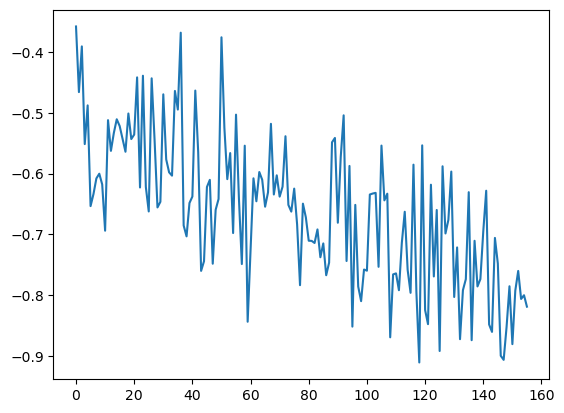

[0.01167782 0.00701685 0.15726408 0.08570702 0.06001804 0.02458618
 0.90240614 0.38625539]
0.002132841652546128
(-0.8058263914273809+0j)
[0.01168213 0.00702647 0.15728443 0.08582316 0.06002058 0.02461733
 0.9022087  0.38667963]
0.002293257085834612
(-0.8251344876917345+0j)
[0.01168709 0.00703695 0.15731654 0.0859525  0.060021   0.02464968
 0.90199577 0.38713184]
0.0023846160490365136
(-0.7803882679586276+0j)
[0.01169095 0.00704721 0.15734136 0.08608349 0.06001784 0.02468236
 0.90177373 0.38760776]
0.00240361774958847
(-0.8033512819347381+0j)
[0.01169507 0.00705769 0.1573581  0.08621217 0.06001916 0.02471706
 0.90155037 0.38808891]
0.0023794596019931853
(-0.8095532860214436+0j)
Epoch 160, Hamiltonian Expectation Value: (-0.8095532860214436+0j)


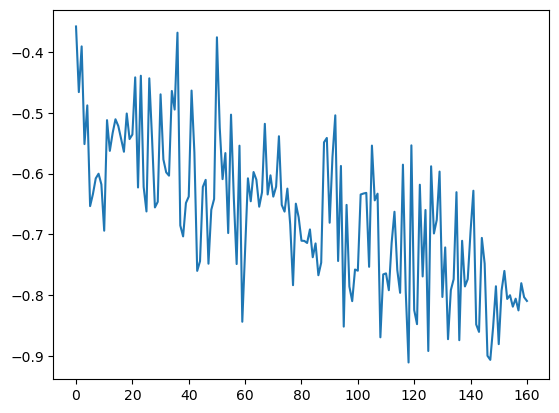

[0.01169915 0.00706801 0.1573903  0.08634621 0.06001429 0.02474875
 0.90132824 0.38856014]
0.0021836761428709866
(-0.7639949447966032+0j)
[0.01170464 0.00707837 0.15743407 0.08647509 0.06001354 0.02477865
 0.90112504 0.38898269]
0.0023302367717725463
(-0.9303533995646058+0j)
[0.01171016 0.00708922 0.15748194 0.08661328 0.06001052 0.0248097
 0.90090756 0.38943417]
0.002313536752865318
(-0.7667038711197484+0j)
[0.01171525 0.00709999 0.15750452 0.08674064 0.06001499 0.02484436
 0.90069077 0.38989464]
0.0026113047094957695
(-0.9138337103676615+0j)
[0.01171988 0.00711145 0.15753941 0.08688848 0.06001047 0.0248796
 0.90044488 0.39041333]
0.0022712094341365507
(-0.9016741474897739+0j)
Epoch 165, Hamiltonian Expectation Value: (-0.9016741474897739+0j)


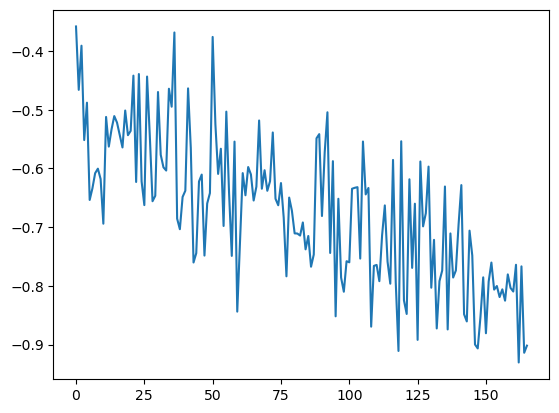

[0.01172417 0.00712166 0.1575586  0.08701268 0.06001217 0.02491283
 0.90023069 0.39086891]
0.002430819784703993
(-0.7508652430149242+0j)
[0.01172823 0.00713228 0.15758633 0.08714875 0.06000839 0.0249461
 0.90000066 0.39135498]
0.0022228500070271408
(-0.9291439476095915+0j)
[0.01173167 0.00714184 0.15760722 0.0872714  0.06000519 0.0249767
 0.89979024 0.3918011 ]
0.0023148474896924074
(-0.8207543028152172+0j)
[0.01173759 0.00715311 0.15763496 0.08740186 0.06001185 0.02501227
 0.89957109 0.39226014]
0.0021492927235524004
(-0.9788335668882184+0j)
[0.01174168 0.00716281 0.15765658 0.0875215  0.06001221 0.02504318
 0.89936695 0.39269031]
0.002464383136117791
(-0.7908795726918928+0j)
Epoch 170, Hamiltonian Expectation Value: (-0.7908795726918928+0j)


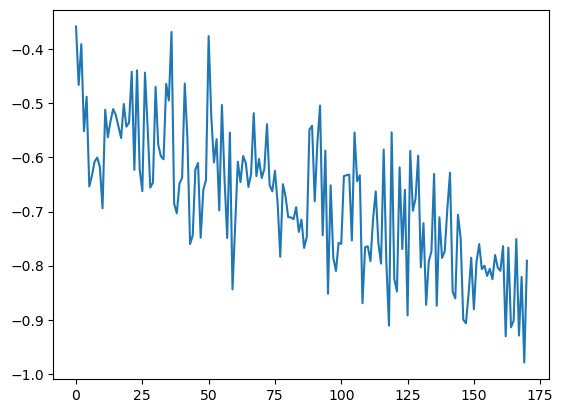

[0.01174649 0.00717404 0.15768055 0.08765853 0.06001348 0.02507909
 0.89913244 0.39318401]
0.0021113136572387713
(-0.9465399657078254+0j)
[0.01175044 0.00718348 0.15771307 0.08778094 0.06000901 0.02510735
 0.89893096 0.39360271]
0.0025240476328625043
(-0.722512850169616+0j)
[0.01175339 0.00719394 0.15772848 0.08791742 0.0600033  0.02514184
 0.89868937 0.3941158 ]
0.0022650277386794338
(-0.7746886641593757+0j)
[0.01175801 0.00720442 0.15775154 0.08804425 0.06000491 0.02517514
 0.89847249 0.39456979]
0.0022210143656906725
(-1.0063015670760271+0j)
[0.01176181 0.00721418 0.15778539 0.08817321 0.0599984  0.02520421
 0.89825961 0.39501073]
0.002236618281430829
(-0.8676652414250324+0j)
Epoch 175, Hamiltonian Expectation Value: (-0.8676652414250324+0j)


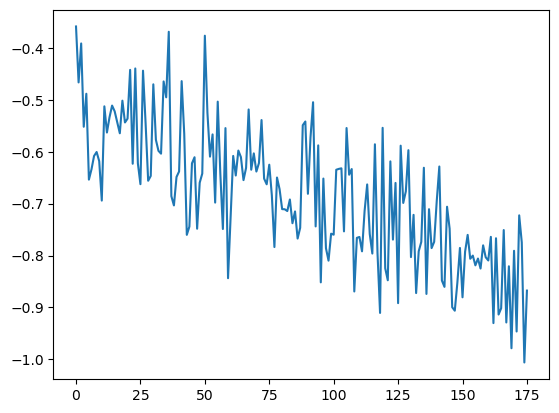

[0.01176643 0.00722453 0.15781751 0.08830287 0.05999665 0.02523565
 0.8980439  0.39545708]
0.0021572837374050613
(-0.8869320704629587+0j)
[0.0117721  0.00723506 0.1578643  0.08843433 0.05999532 0.02526537
 0.8978368  0.395877  ]
0.002374849609572946
(-0.927331871001468+0j)
[0.01177611 0.00724562 0.15788819 0.08856798 0.05999268 0.02529877
 0.89760702 0.39635633]
0.0024501366235966256
(-0.8864403143241351+0j)
[0.01178048 0.00725665 0.15791568 0.0887073  0.05999001 0.02533324
 0.89736947 0.39684968]
0.0025189608801605484
(-0.8650614547519062+0j)
[0.01178499 0.00726804 0.1579361  0.08884734 0.05999035 0.02537008
 0.89712524 0.39735935]
0.00238791103282105
(-0.8962059751528447+0j)
Epoch 180, Hamiltonian Expectation Value: (-0.8962059751528447+0j)


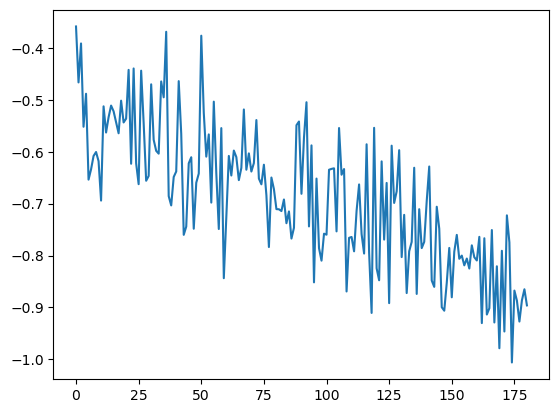

[0.01178809 0.00727817 0.15795951 0.08898169 0.05998288 0.02540195
 0.89689294 0.3978429 ]
0.002503362610250204
(-0.9047898203125317+0j)
[0.01179312 0.00728977 0.1579919  0.08912654 0.05998136 0.02543755
 0.89664883 0.39834514]
0.002150706186566964
(-0.9095120873673133+0j)
[0.01179722 0.00729968 0.15800908 0.08924654 0.05998289 0.02546967
 0.89643876 0.39878142]
0.0022375873857127856
(-0.7013350701463072+0j)
[0.01180165 0.00731    0.15804313 0.08937838 0.05997915 0.02550045
 0.89621987 0.39922842]
0.00220520200639824
(-0.7837393303118685+0j)
[0.01180499 0.00731972 0.15805469 0.08949896 0.05997852 0.0255327
 0.89600389 0.39967912]
0.002367128995596388
(-0.8347213192940188+0j)
Epoch 185, Hamiltonian Expectation Value: (-0.8347213192940188+0j)


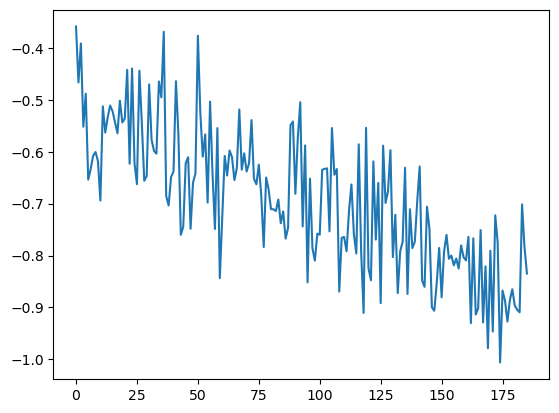

[0.01180825 0.00732997 0.15807043 0.08963    0.0599748  0.02556609
 0.89577147 0.40016236]
0.0020149980284400295
(-0.9074474556030933+0j)
[0.01181043 0.0073384  0.15807976 0.08973976 0.05997002 0.02559413
 0.89557295 0.40057691]
0.002486061163492874
(-0.8628677694961443+0j)
[0.011817   0.00735094 0.15810924 0.08988327 0.05997753 0.02563332
 0.89532895 0.40107416]
0.002088913864639965
(-0.8045476037451211+0j)
[0.01182127 0.00736069 0.15814161 0.09000739 0.05997435 0.02566227
 0.8951229  0.4014916 ]
0.002247479916606834
(-0.9749665219444408+0j)
[0.01182497 0.00737081 0.15816121 0.09013465 0.05997202 0.02569452
 0.89490014 0.40194962]
0.002482808222877982
(-0.7571481765427042+0j)
Epoch 190, Hamiltonian Expectation Value: (-0.7571481765427042+0j)


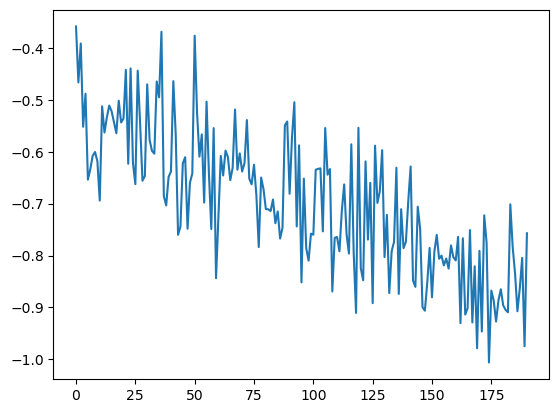

[0.01182858 0.00738173 0.15817895 0.09027361 0.05996844 0.02572985
 0.8946538  0.40245749]
0.0021764206919500815
(-0.8589531614868926+0j)
[0.01183228 0.00739153 0.15821144 0.09040272 0.0599615  0.02575886
 0.89443737 0.40289546]
0.002032802491185564
(-0.8949404773338229+0j)
[0.01183667 0.00740119 0.15824565 0.09052526 0.05995847 0.02578706
 0.89423546 0.40330082]
0.0024296440205130074
(-1.1397271655951775+0j)
[0.01184188 0.00741281 0.15827915 0.09066899 0.05995736 0.02582222
 0.89399313 0.4037899 ]
0.0025289912684721494
(-0.9738082958108587+0j)
[0.01184708 0.00742485 0.15830815 0.09081631 0.05995728 0.02585951
 0.8937401  0.40430248]
0.002514091514677924
(-0.9979906749102188+0j)
Epoch 195, Hamiltonian Expectation Value: (-0.9979906749102188+0j)


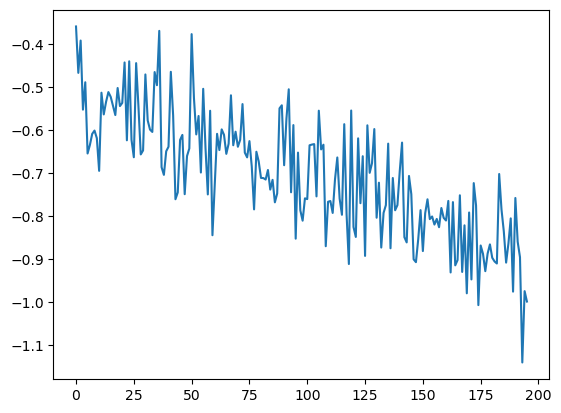

[0.01185117 0.0074362  0.15833549 0.09096215 0.05995205 0.02589462
 0.89348791 0.40481427]
0.0027751433318420086
(-0.7980159809437859+0j)
[0.01185421 0.00744795 0.1583484  0.09111545 0.05994528 0.02593346
 0.89320941 0.40538715]
0.0021767637061879137
(-0.9099081552286594+0j)
[0.01185753 0.00745768 0.1583678  0.0912402  0.05994116 0.02596416
 0.89299024 0.40583249]
0.0021189997449718974
(-0.9057774862721751+0j)
[0.01186135 0.00746753 0.15838644 0.09136186 0.05994033 0.02599543
 0.89277614 0.40626648]
0.002377742960237215
(-1.045810495891855+0j)
[0.01186535 0.00747833 0.15841805 0.09150292 0.05993371 0.02602787
 0.89253588 0.40674861]
0.002620748184145145
(-0.9333467092951528+0j)
Epoch 200, Hamiltonian Expectation Value: (-0.9333467092951528+0j)


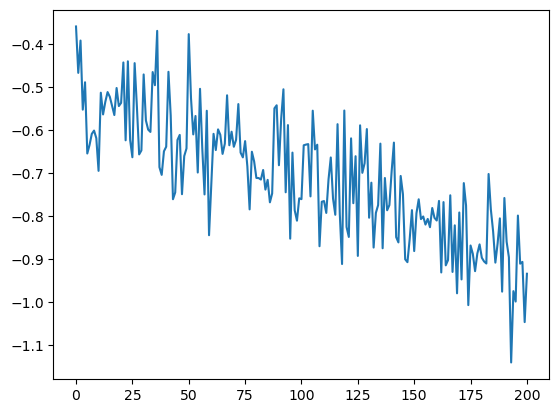

[0.01186969 0.00749029 0.15844001 0.09165317 0.05993106 0.02606583
 0.89227093 0.40728478]
0.0024812018240972077
(-1.0107524409007447+0j)
[0.01187362 0.00750145 0.15847445 0.09180126 0.05992228 0.02609894
 0.89201929 0.40778777]
0.0026851396706412643
(-0.9547713067356965+0j)
[0.01187826 0.00751391 0.15849864 0.09195636 0.0599197  0.0261381
 0.89174649 0.40833721]
0.0023790244442937624
(-0.8196168361561824+0j)
[0.01188194 0.00752467 0.15851744 0.09209284 0.0599162  0.02617233
 0.89150419 0.40882597]
0.0027647231083947994
(-0.7967712537990876+0j)
[0.01188634 0.00753727 0.15853978 0.09225194 0.05991255 0.02621235
 0.89122178 0.40939438]
0.002852061164371276
(-0.8593218326812868+0j)
Epoch 205, Hamiltonian Expectation Value: (-0.8593218326812868+0j)


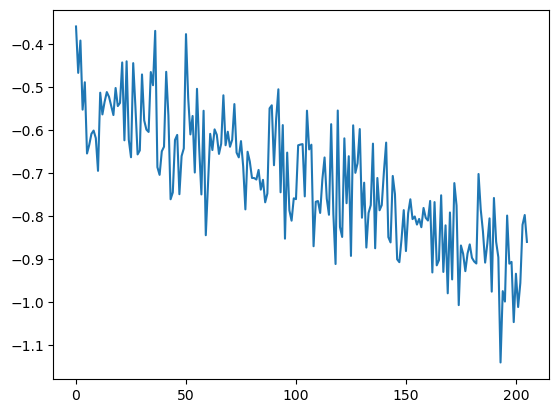

[0.01189303 0.00755155 0.15857199 0.09242044 0.05991628 0.02625652
 0.89093032 0.40997403]
0.0029315449578215507
(-0.7259883217570399+0j)
[0.01189611 0.00756405 0.15858853 0.09258602 0.05990681 0.026297
 0.89062973 0.41058142]
0.002546989712378419
(-1.0070253742218085+0j)
[0.01190124 0.00757624 0.15862557 0.09274055 0.05990253 0.02633308
 0.89036798 0.41109754]
0.002559917218887516
(-1.0107429977814895+0j)
[0.01190684 0.00758889 0.15863553 0.09288332 0.05991107 0.02637523
 0.89010617 0.41162375]
0.0022657193417990325
(-1.0534124639725782+0j)
[0.01191177 0.00759997 0.15866913 0.09302149 0.05990886 0.02640797
 0.88987274 0.41208194]
0.0024771998945373355
(-0.808821093611222+0j)
Epoch 210, Hamiltonian Expectation Value: (-0.808821093611222+0j)


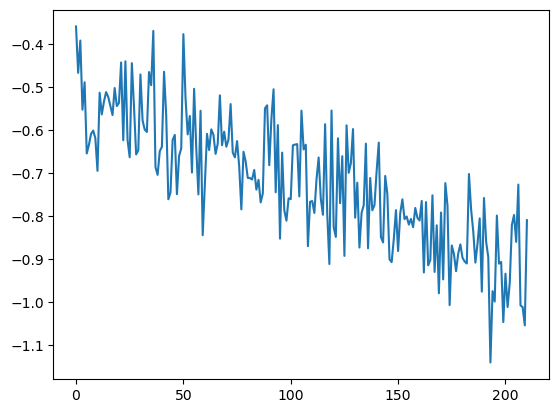

[0.01191777 0.00761249 0.1587074  0.09317356 0.05990884 0.02644491
 0.88961634 0.41258336]
0.002337025792386798
(-0.9685165466382268+0j)
[0.01192029 0.00762262 0.15871519 0.09330421 0.05990342 0.02647854
 0.88937377 0.41307188]
0.002911888997005449
(-0.8694520230819869+0j)
[0.01192278 0.00763488 0.15872051 0.09346498 0.05989496 0.02651986
 0.88907108 0.41368293]
0.0021838325950587173
(-0.9517088719479089+0j)
[0.01192601 0.00764481 0.15874229 0.09359413 0.05988872 0.02655045
 0.88884317 0.41413352]
0.0025235574369010597
(-0.8156209829727363+0j)
[0.01192978 0.00765641 0.15875299 0.09373706 0.05988731 0.02658858
 0.88857976 0.41465948]
0.0026024382979162974
(-1.1204643422081513+0j)
Epoch 215, Hamiltonian Expectation Value: (-1.1204643422081513+0j)


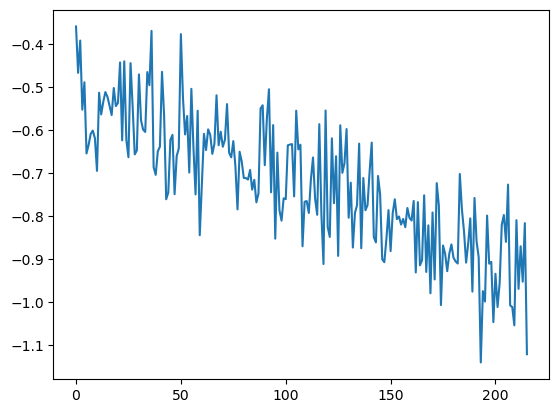

[0.01193446 0.00766883 0.15876699 0.09388607 0.05988874 0.02662903
 0.88830766 0.41519988]
0.002245694052329222
(-0.8697808574229731+0j)
[0.01193778 0.00767906 0.15879039 0.09401984 0.05988191 0.02666033
 0.88807197 0.41566328]
0.0025945368713634577
(-0.89143664808783+0j)
[0.01194296 0.00769171 0.15882114 0.09417657 0.05987944 0.02669866
 0.88779924 0.41619583]
0.0025005494180770733
(-0.9271790955524879+0j)
[0.01194732 0.00770357 0.15884356 0.09432457 0.05987651 0.02673565
 0.88753578 0.41671305]
0.002382544287395363
(-0.9358994004556698+0j)
[0.01195192 0.00771511 0.15886596 0.09446623 0.05987565 0.02677155
 0.88728481 0.41720406]
0.002463547354411005
(-0.8492907594498043+0j)
Epoch 220, Hamiltonian Expectation Value: (-0.8492907594498043+0j)


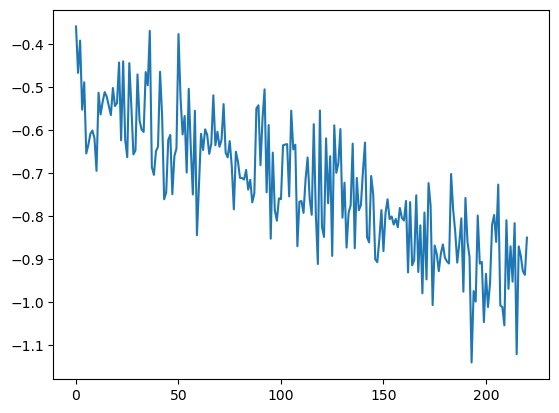

[0.01195513 0.00772618 0.15888908 0.09461258 0.0598666  0.02680559
 0.88702371 0.4177158 ]
0.0023848209206284226
(-1.0829948652928205+0j)
[0.01195695 0.00773629 0.15888292 0.09474085 0.05986221 0.02684117
 0.88677171 0.41822191]
0.0025236397441390575
(-1.0536196582898207+0j)
[0.01195999 0.00774753 0.15889668 0.09488667 0.05985548 0.02687732
 0.88650387 0.41874946]
0.0022863741349689456
(-0.9182656055465858+0j)
[0.01196442 0.00775865 0.15892609 0.09502692 0.0598515  0.02691049
 0.88626053 0.41921943]
0.0023679805657984337
(-1.0792447799582943+0j)
[0.01196864 0.00776997 0.15895575 0.09517178 0.05984573 0.02694416
 0.88600861 0.41970587]
0.0023349504619208992
(-1.0458122885180399+0j)
Epoch 225, Hamiltonian Expectation Value: (-1.0458122885180399+0j)


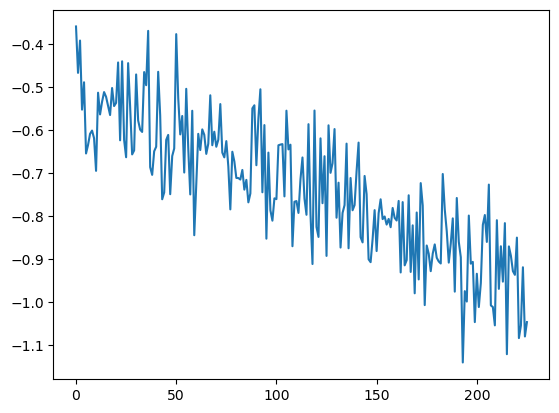

[0.01197387 0.00778182 0.15898024 0.09531294 0.05984727 0.02698062
 0.88575941 0.42018737]
0.002637366274713817
(-0.9118600361713299+0j)
[0.0119779  0.00779411 0.15900218 0.09546987 0.05984155 0.02701889
 0.88547714 0.42073602]
0.0023704321129761593
(-1.1216335161523387+0j)
[0.01198416 0.00780665 0.15903638 0.09561765 0.05984443 0.02705606
 0.88522399 0.42121874]
0.0025686304809407036
(-0.7944827028332714+0j)
[0.01198783 0.0078186  0.15904121 0.09576307 0.05984382 0.02709598
 0.88494855 0.42175951]
0.0026795528767484386
(-0.8809804415229274+0j)
[0.01199308 0.00783179 0.15907419 0.09592818 0.05983973 0.02713539
 0.88466017 0.42231182]
0.0024296812630277597
(-1.1215988561750443+0j)
Epoch 230, Hamiltonian Expectation Value: (-1.1215988561750443+0j)


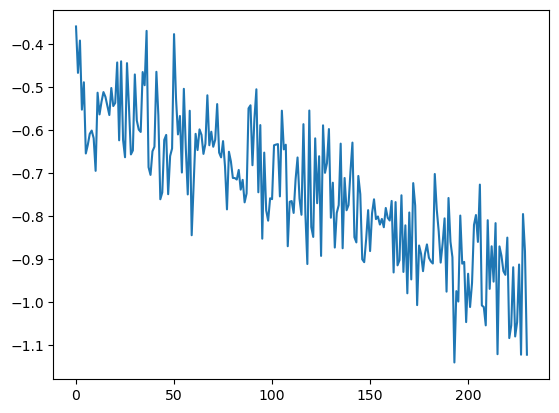

[0.01199642 0.00784298 0.15909278 0.09607281 0.05983293 0.02717034
 0.88439739 0.42282044]
0.0021505336962061336
(-0.9903339526565488+0j)
[0.01199975 0.0078531  0.15911251 0.09620256 0.05982758 0.02720144
 0.88416454 0.42326874]
0.0025515612231345303
(-0.8847192361538297+0j)
[0.01200424 0.00786556 0.15911883 0.09634851 0.05983046 0.02724278
 0.88388878 0.42380534]
0.0024133693143218666
(-0.958837536412496+0j)
[0.0120078  0.00787684 0.15914021 0.09649412 0.05982369 0.02727749
 0.88362631 0.42430963]
0.002282336734977077
(-1.0869220862450635+0j)
[0.01201045 0.00788712 0.1591544  0.09662904 0.05981594 0.02730993
 0.88337791 0.42478928]
0.002436258890014915
(-0.9777187275519211+0j)
Epoch 235, Hamiltonian Expectation Value: (-0.9777187275519211+0j)


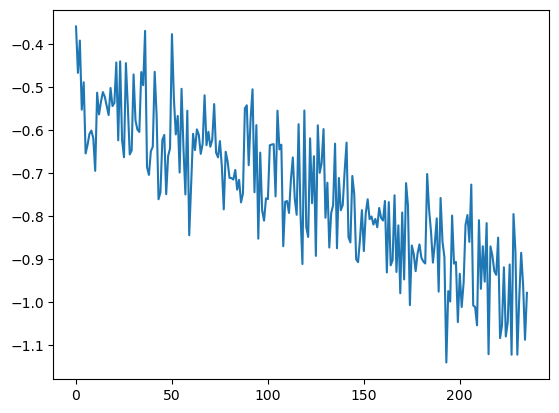

[0.01201578 0.00789947 0.15919021 0.09678297 0.05981259 0.02734587
 0.883113   0.42528912]
0.0027893013350505026
(-0.9290939477981036+0j)
[0.01201985 0.00791262 0.15920213 0.09694598 0.05980937 0.02738839
 0.88280875 0.42587615]
0.0025751306527464187
(-0.9017099890399222+0j)
[0.01202278 0.00792425 0.15921417 0.09709704 0.05980167 0.02742567
 0.88252679 0.42641966]
0.002549213468049979
(-1.0482082501432335+0j)
[0.01202492 0.00793535 0.15922065 0.097244   0.05979212 0.02746206
 0.88224675 0.42696162]
0.002987603004110739
(-1.0827694548172502+0j)
[0.01203023 0.00795003 0.159244   0.09742458 0.05978924 0.02750778
 0.88191804 0.42758744]
0.002800167829936789
(-1.0709925609291902+0j)
Epoch 240, Hamiltonian Expectation Value: (-1.0709925609291902+0j)


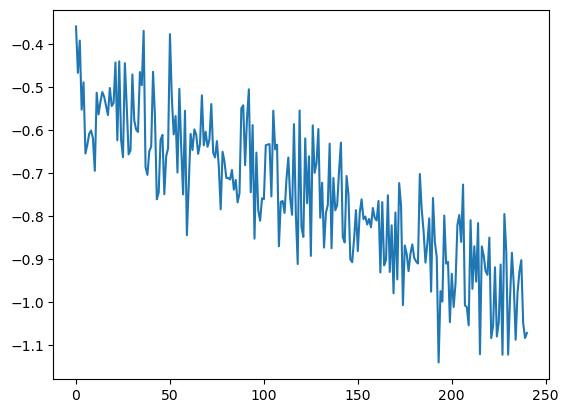

[0.01203173 0.00796179 0.15924014 0.09758089 0.05977857 0.02754802
 0.8816099  0.42818689]
0.0028671632765863886
(-0.9605616129942606+0j)
[0.01203572 0.00797526 0.15925875 0.09775274 0.05977149 0.02759025
 0.88129323 0.42879015]
0.0025611241564381026
(-0.935891678371053+0j)
[0.01204163 0.00798856 0.15929728 0.09791667 0.05976887 0.02762867
 0.8810107  0.42931616]
0.0022502278857689057
(-0.8309208645820418+0j)
[0.01204347 0.00799843 0.15929722 0.09804463 0.05976222 0.0276619
 0.88076096 0.4297977 ]
0.0025223832533999174
(-0.930008845534093+0j)
[0.01204656 0.00801007 0.15930737 0.09819345 0.05975605 0.02769937
 0.88048047 0.43033247]
0.0026877673198084867
(-1.0734813261060312+0j)
Epoch 245, Hamiltonian Expectation Value: (-1.0734813261060312+0j)


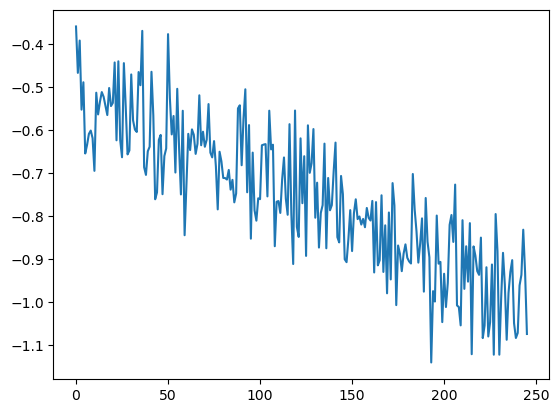

[0.01204881 0.00802191 0.15931021 0.09834811 0.05974722 0.02773863
 0.88018111 0.43090652]
0.0026845544460534685
(-1.127998422339071+0j)
[0.0120532  0.00803507 0.15931933 0.09850628 0.05974673 0.02778141
 0.87988106 0.43147638]
0.002781299554148155
(-1.0800862013428394+0j)
[0.01205617 0.00804775 0.15932631 0.098669   0.05973917 0.02782278
 0.87956954 0.43206941]
0.00253162321599967
(-1.142382750668542+0j)
[0.0120597  0.00805979 0.1593342  0.09881822 0.05973588 0.02786191
 0.87928554 0.43260774]
0.00261443338450304
(-1.0582352897218368+0j)
[0.01206264 0.0080718  0.15934191 0.09897218 0.05972897 0.02790085
 0.87899169 0.43316463]
0.0025981476829808536
(-1.203538352201036+0j)
Epoch 250, Hamiltonian Expectation Value: (-1.203538352201036+0j)


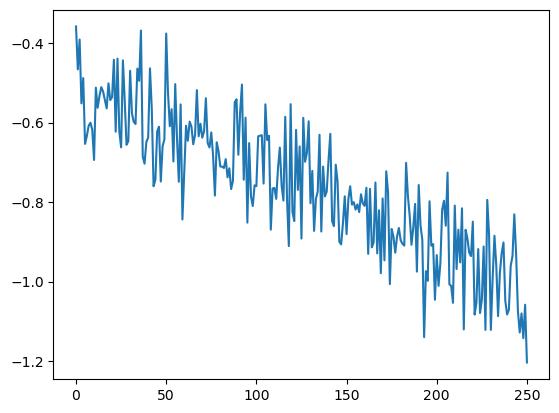

[0.01206687 0.00808452 0.1593618  0.09913152 0.05972407 0.0279401
 0.87869894 0.43371228]
0.002419962568361869
(-1.1097034594777524+0j)
[0.01206986 0.00809592 0.15936244 0.09927132 0.05972138 0.02797821
 0.87842547 0.43423135]
0.0024959141090108274
(-0.9239947113090807+0j)
[0.0120746  0.0081086  0.15938289 0.09942551 0.05971945 0.02801724
 0.87814305 0.43475685]
0.0026211781041825984
(-1.1325467320381046+0j)
[0.01207787 0.00812085 0.15940342 0.09958685 0.05970906 0.02805463
 0.87784561 0.43531143]
0.0024008329415802607
(-1.0864261800307473+0j)
[0.01208203 0.0081328  0.15942175 0.0997349  0.05970566 0.02809147
 0.87757324 0.43581744]
0.0024404212440257813
(-1.1201384268576675+0j)
Epoch 255, Hamiltonian Expectation Value: (-1.1201384268576675+0j)


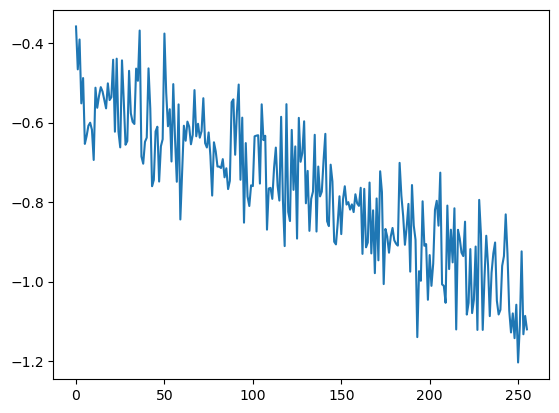

[0.01208549 0.00814453 0.15943281 0.09988186 0.05970111 0.02812875
 0.87729568 0.43633615]
0.0022233524218439973
(-1.0491331456974597+0j)
[0.01208812 0.00815493 0.15944326 0.10001606 0.05969408 0.02816166
 0.8770414  0.43681109]
0.0027638250545154366
(-0.9969326558949129+0j)
[0.01209136 0.00816789 0.1594533  0.1001817  0.05968623 0.02820313
 0.87672492 0.43740245]
0.00248657509895874
(-1.1662949932540814+0j)
[0.0120956  0.00818032 0.15947285 0.10033624 0.05968183 0.02824125
 0.87643957 0.43792925]
0.0028522921460720765
(-1.1392524127146222+0j)
[0.01209934 0.00819397 0.1594779  0.10050508 0.05967773 0.02828592
 0.87611202 0.43854098]
0.002453978733854379
(-1.1113084698116726+0j)
Epoch 260, Hamiltonian Expectation Value: (-1.1113084698116726+0j)


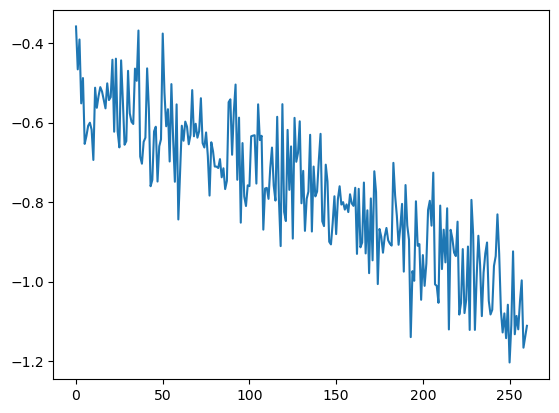

[0.01210225 0.00820557 0.15948529 0.10065208 0.05967135 0.02832321
 0.8758291  0.43906755]
0.0026123063060108647
(-1.1767335200407096+0j)
[0.01210533 0.00821779 0.15950268 0.10081314 0.05966092 0.02836074
 0.87552851 0.43962211]
0.002489226929589134
(-0.9324270010708229+0j)
[0.01211211 0.00823177 0.15954295 0.10097791 0.0596614  0.02840031
 0.87524343 0.44013398]
0.0023398249016521578
(-1.012657582467663+0j)
[0.01211544 0.00824322 0.15954889 0.10111819 0.05965843 0.02843734
 0.87497218 0.44063635]
0.0023829566116992207
(-1.0844760341085051+0j)
[0.01211785 0.00825419 0.15956255 0.10126457 0.05964753 0.02847127
 0.87469602 0.44114481]
0.002495583927202067
(-0.9625092182972399+0j)
Epoch 265, Hamiltonian Expectation Value: (-0.9625092182972399+0j)


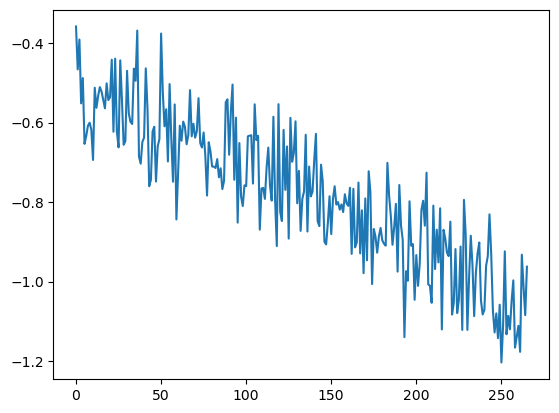

[0.01212046 0.00826581 0.15957121 0.10141554 0.05963866 0.02850822
 0.87440553 0.44168108]
0.0026330611908418258
(-1.0975845485431972+0j)
[0.01212695 0.00828024 0.15960938 0.10158915 0.05963718 0.02854958
 0.87410042 0.44222804]
0.0023658264332366828
(-0.9959800164348069+0j)
[0.01213026 0.0082918  0.15962307 0.1017356  0.0596308  0.02858548
 0.87382378 0.44273411]
0.002661589190412602
(-0.9978871012946918+0j)
[0.0121345  0.00830514 0.15963314 0.10189793 0.0596282  0.02862795
 0.8735127  0.44330388]
0.002518180170443204
(-1.1380315265393455+0j)
[0.01214103 0.00831927 0.15965757 0.1020586  0.05963293 0.02867069
 0.87321988 0.44383086]
0.002630140725234658
(-1.0743852940489607+0j)
Epoch 270, Hamiltonian Expectation Value: (-1.0743852940489607+0j)


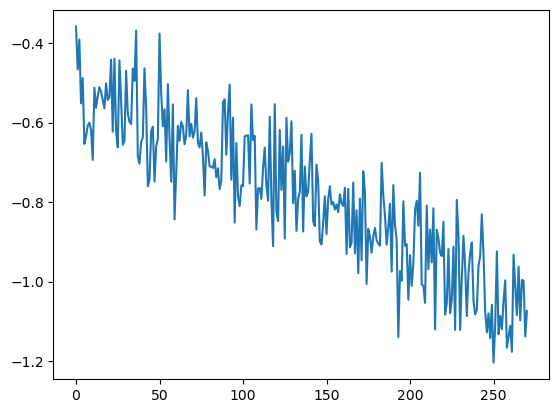

[0.01214487 0.00833235 0.15966322 0.10221732 0.05963009 0.02871297
 0.87291082 0.4443972 ]
0.0025289175706794433
(-1.1869076149912432+0j)
[0.01214777 0.00834441 0.15966916 0.10237033 0.05962312 0.02875169
 0.87261285 0.44494282]
0.002709430400647586
(-1.12209914399363+0j)
[0.01215104 0.00835743 0.1596803  0.10253675 0.05961455 0.02879253
 0.87229342 0.44552464]
0.0026453791278736845
(-1.0618741200113966+0j)
[0.01215599 0.00837121 0.15970128 0.10270477 0.05961129 0.02883439
 0.87198095 0.44608709]
0.002612513780164954
(-1.1671740516375635+0j)
[0.01216052 0.00838455 0.15972523 0.1028724  0.05960504 0.02887416
 0.87167234 0.44664056]
0.0027276624555602107
(-1.1497394289077818+0j)
Epoch 275, Hamiltonian Expectation Value: (-1.1497394289077818+0j)


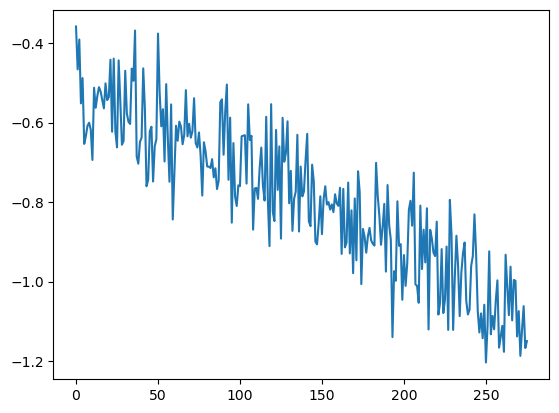

[0.01216304 0.00839725 0.15973089 0.10303786 0.05959453 0.02891485
 0.87134815 0.44723105]
0.0025228317066687237
(-1.2143094679067838+0j)
[0.01216667 0.00840977 0.15974737 0.10319697 0.05958702 0.02895309
 0.87104804 0.44777096]
0.002635411279830377
(-1.1567243199050026+0j)
[0.01216952 0.00842232 0.15975425 0.10335813 0.05957833 0.02899306
 0.87073351 0.44834096]
0.0025170661508017557
(-1.1554288835836635+0j)
[0.0121739  0.0084353  0.15977673 0.10352022 0.05957232 0.02903169
 0.87043348 0.44887578]
0.002625703347358159
(-1.0721808643465802+0j)
[0.01217632 0.00844756 0.1597816  0.10368007 0.05956222 0.0290709
 0.87011951 0.449444  ]
0.002601771471061123
(-1.1621249798544142+0j)
Epoch 280, Hamiltonian Expectation Value: (-1.1621249798544142+0j)


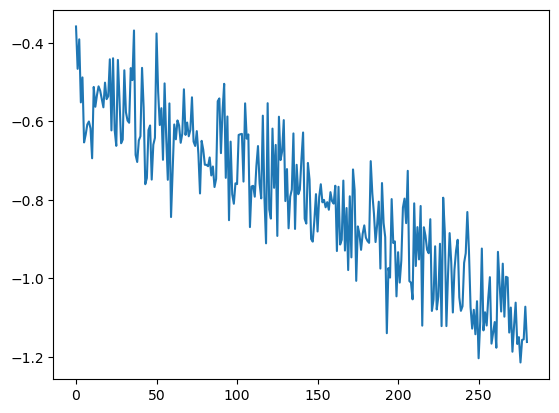

[0.01218024 0.00846069 0.15979388 0.10384282 0.05955686 0.02911176
 0.8698073  0.45000377]
0.0028139401035399193
(-1.0164439333569946+0j)
[0.01218345 0.0084743  0.15979959 0.10401513 0.05954877 0.02915525
 0.86946879 0.45061361]
0.0026395135307344325
(-1.1640405421722568+0j)
[0.01218547 0.00848643 0.15980397 0.10417615 0.05953656 0.02919401
 0.86915056 0.45118723]
0.002335001863884463
(-1.0968178149662424+0j)
[0.01219068 0.00849931 0.1598268  0.10432871 0.05953562 0.02923226
 0.86886901 0.45168317]
0.0025886972641016633
(-1.1516770904882514+0j)
[0.01219317 0.00851155 0.15983304 0.10448823 0.05952536 0.02927103
 0.86855587 0.45224454]
0.0026109918622667597
(-1.0233433226890998+0j)
Epoch 285, Hamiltonian Expectation Value: (-1.0233433226890998+0j)


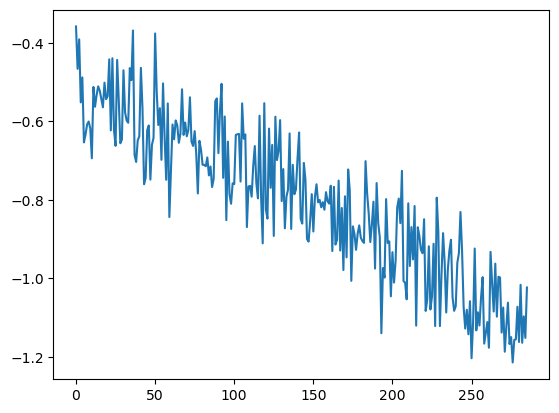

[0.01219713 0.00852488 0.15984516 0.10465251 0.05951997 0.02931234
 0.86823948 0.45280714]
0.0021130915397122975
(-1.0015663162335593+0j)
[0.01220222 0.00853676 0.15986664 0.10479121 0.05952075 0.02934748
 0.86798475 0.45325287]
0.0025410465435495907
(-1.2344143500183389+0j)
[0.01220734 0.00855043 0.15989425 0.10495944 0.05951591 0.02938726
 0.86767656 0.45379163]
0.002798766833322114
(-0.9175917826939298+0j)
[0.01221143 0.00856459 0.15990924 0.1051373  0.0595085  0.02943066
 0.86733603 0.45439354]
0.002807104117423866
(-1.1432245836903465+0j)
[0.01221472 0.00857828 0.15992832 0.10531772 0.05949538 0.02947168
 0.86699313 0.45499775]
0.0027600953914576763
(-0.9625217872493774+0j)
Epoch 290, Hamiltonian Expectation Value: (-0.9625217872493774+0j)


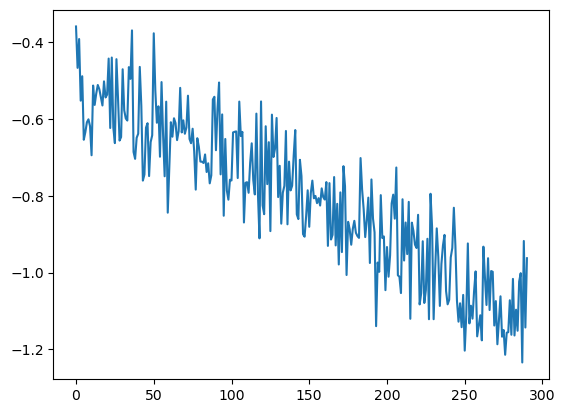

[0.01221869 0.00859224 0.15994797 0.1054961  0.05948573 0.0295135
 0.86665529 0.45559094]
0.0028744935950110835
(-1.1834962366915358+0j)
[0.01222297 0.00860686 0.15997081 0.10568329 0.05947561 0.02955685
 0.86630341 0.45620648]
0.002770615195532645
(-0.9853139410988642+0j)
[0.01222628 0.00862056 0.15997798 0.10585654 0.05946714 0.02959997
 0.86596237 0.45680885]
0.0024692262185139085
(-1.1590133993264229+0j)
[0.0122297  0.00863313 0.15998369 0.10601092 0.05946212 0.02963972
 0.86565757 0.45734617]
0.002853904855165144
(-1.1079156505768701+0j)
[0.012233   0.0086472  0.15999    0.10618928 0.05945321 0.0296841
 0.86530532 0.45796669]
0.002590592449488061
(-1.1407442479238894+0j)
Epoch 295, Hamiltonian Expectation Value: (-1.1407442479238894+0j)


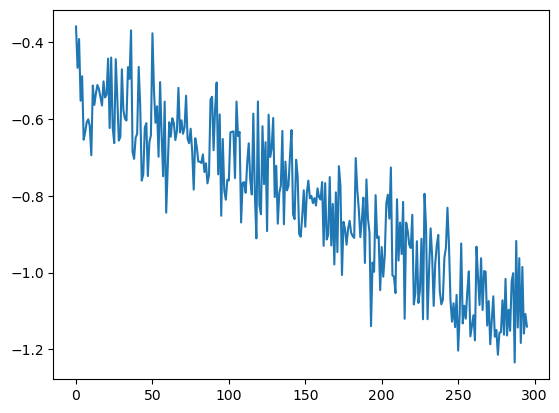

[0.01223574 0.0086598  0.16000324 0.10635512 0.05944086 0.02972234
 0.86498428 0.45852853]
0.0029303245460917293
(-1.1823489046741769+0j)
[0.01223688 0.00867288 0.15999464 0.10653021 0.05942601 0.02976585
 0.86462112 0.45917418]
0.002830882371278646
(-1.14497571555078+0j)
[0.01223874 0.008686   0.15999496 0.1067044  0.05941214 0.02980791
 0.86426934 0.45979424]
0.0024752617670935825
(-1.1744292256876907+0j)
[0.01224344 0.00869942 0.16001481 0.10686756 0.05940784 0.02984778
 0.86396128 0.46032567]
0.002396590795100213
(-1.243299821815807+0j)
[0.01224714 0.00871192 0.16002696 0.10702213 0.05940213 0.02988593
 0.8636621  0.46084459]
0.0027726088708263713
(-1.0724856977543167+0j)
Epoch 300, Hamiltonian Expectation Value: (-1.0724856977543167+0j)


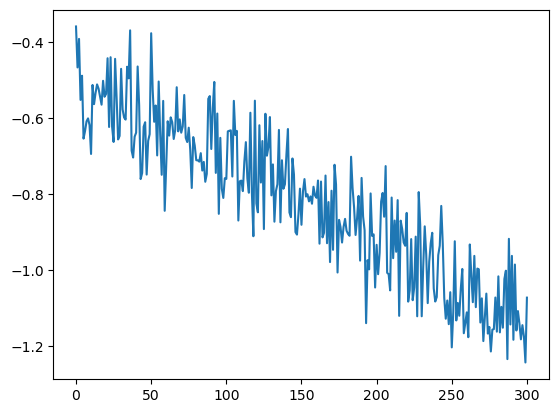

[0.01225007 0.0087255  0.16003336 0.10719696 0.05939164 0.02992841
 0.8633158  0.46144847]
0.0027263518508820533
(-1.1693600321685556+0j)
[0.01225356 0.00873931 0.1600424  0.10737076 0.05938319 0.0299712
 0.8629739  0.46204203]
0.002866314796626377
(-1.1341065356625197+0j)
[0.01225765 0.00875414 0.16003521 0.10754444 0.05938283 0.0300204
 0.86261568 0.46266908]
0.002859692470182391
(-1.2655202882952126+0j)
[0.01226018 0.00876791 0.16004441 0.10772662 0.05936829 0.0300627
 0.86225583 0.46329267]
0.0027373959812727992
(-1.4283772540267143+0j)
[0.01226226 0.00878094 0.16004071 0.10789487 0.05935739 0.03010503
 0.86191035 0.46389561]
0.003051178626174444
(-1.2621880595607005+0j)
Epoch 305, Hamiltonian Expectation Value: (-1.2621880595607005+0j)


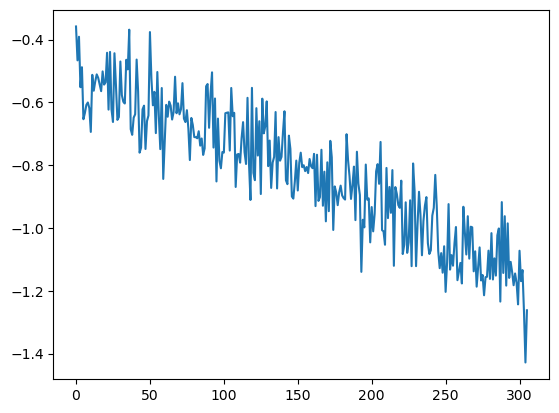

[0.0122658  0.00879633 0.16004319 0.10808658 0.0593486  0.03015389
 0.86152351 0.4645658 ]
0.002480509112340963
(-1.2173218401017922+0j)
[0.01226972 0.00880949 0.1600479  0.10824391 0.05934562 0.03019534
 0.86120954 0.4651067 ]
0.003085415091035484
(-1.2746776760373408+0j)
[0.01227187 0.00882411 0.16004681 0.10843597 0.05933093 0.03024208
 0.86081739 0.46578631]
0.002432462272902805
(-1.1953651440870436+0j)
[0.01227511 0.00883669 0.16004281 0.10858606 0.05932826 0.03028318
 0.86050834 0.46632079]
0.002795078722246065
(-1.3158647125063176+0j)
[0.01227603 0.0088493  0.16003516 0.10875648 0.0593123  0.03032444
 0.86015261 0.46693867]
0.002771380211373171
(-1.385739802405996+0j)
Epoch 310, Hamiltonian Expectation Value: (-1.385739802405996+0j)


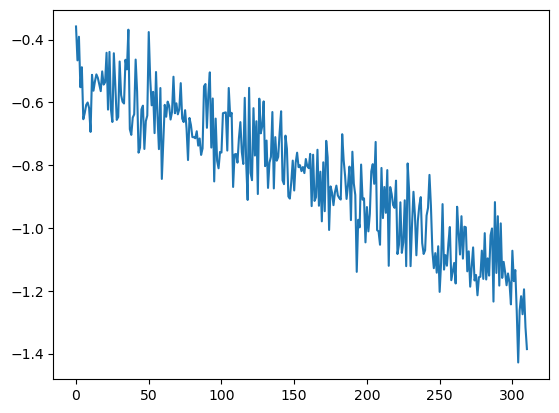

[0.01227713 0.00886199 0.16002232 0.10892309 0.05929927 0.03036701
 0.85979844 0.46755475]
0.002675708274886446
(-1.1239487834012116+0j)
[0.01228004 0.00887544 0.1600263  0.10909354 0.05928959 0.03040911
 0.8594553  0.46814231]
0.002502325008155195
(-1.0749669998680547+0j)
[0.01228466 0.00888919 0.16004367 0.10926041 0.0592849  0.03044997
 0.85913469 0.4686832 ]
0.0025373995853326995
(-1.3116781691358363+0j)
[0.01228667 0.00890142 0.1600481  0.10942251 0.05927169 0.03048792
 0.85880832 0.46924061]
0.002687053455066593
(-1.2689936539152025+0j)
[0.01228798 0.00891392 0.16003876 0.10958671 0.05925896 0.03052913
 0.85846241 0.46983671]
0.0026015909633550004
(-1.3946206869698738+0j)
Epoch 315, Hamiltonian Expectation Value: (-1.3946206869698738+0j)


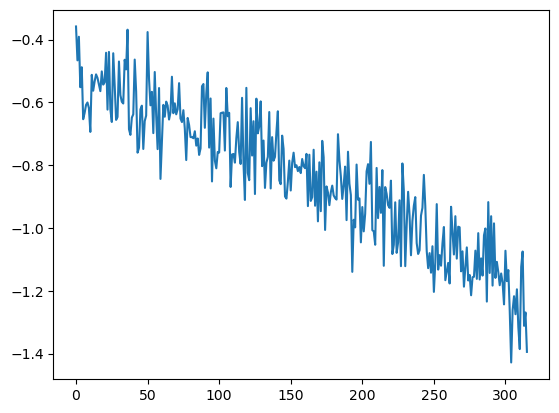

[0.01228873 0.00892571 0.16002698 0.10974422 0.05924495 0.03056843
 0.85812656 0.4704161 ]
0.0025133648980311487
(-1.1732422889051706+0j)
[0.0122922  0.0089389  0.16003287 0.10990665 0.05923848 0.03060933
 0.85780134 0.47096682]
0.0027950063139424047
(-1.2310238146023855+0j)
[0.01229698 0.00895409 0.16004861 0.11009229 0.05923254 0.0306548
 0.85744062 0.47157196]
0.0027516418361022248
(-1.2515979608453165+0j)
[0.01229874 0.00896728 0.16004059 0.11026249 0.0592206  0.03069792
 0.85708236 0.47218418]
0.0027401930595973446
(-1.23057283814373+0j)
[0.01229972 0.00897993 0.16002662 0.11042863 0.05920714 0.03074027
 0.85672542 0.47279614]
0.003082815436844529
(-1.203469652048645+0j)
Epoch 320, Hamiltonian Expectation Value: (-1.203469652048645+0j)


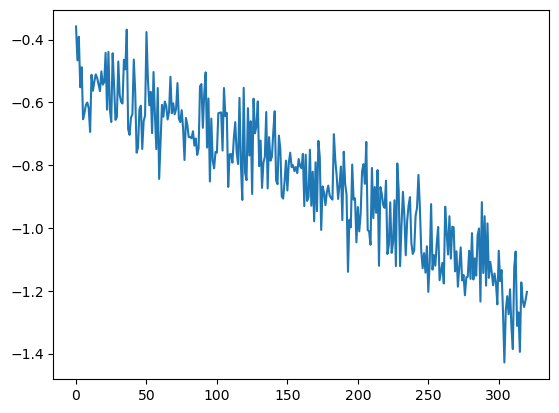

[0.01230271 0.00899543 0.16001938 0.11062097 0.05919809 0.03079059
 0.85632326 0.47347917]
0.00264761247701198
(-1.2004065250152218+0j)
[0.01230613 0.00900922 0.16002839 0.11079476 0.05918879 0.03083255
 0.85597729 0.47405879]
0.0028247051370037172
(-1.174419946482805+0j)
[0.01231117 0.00902491 0.16003869 0.11098079 0.05918544 0.03088052
 0.85560802 0.4746749 ]
0.002724720155570752
(-1.2702952221768866+0j)
[0.01231488 0.0090393  0.16004721 0.11115983 0.05917697 0.03092441
 0.85525032 0.4752722 ]
0.002809966742901823
(-1.3229831534013725+0j)
[0.01231784 0.00905357 0.1600534  0.11134298 0.05916489 0.03096804
 0.85488159 0.47588856]
0.0028217095231737816
(-1.181026523519057+0j)
Epoch 325, Hamiltonian Expectation Value: (-1.181026523519057+0j)


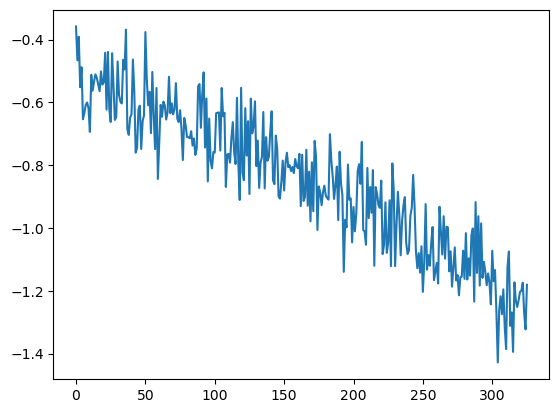

[0.01232013 0.0090675  0.16005197 0.11152313 0.05915214 0.03101202
 0.85450928 0.47651351]
0.002454718415473495
(-1.2796609487926252+0j)
[0.01232155 0.00907929 0.16004821 0.11167851 0.05913905 0.03104953
 0.85418466 0.47705901]
0.0027266718510074537
(-1.394195445140829+0j)
[0.01232429 0.00909316 0.16005048 0.11185521 0.0591278  0.03109261
 0.85382326 0.47766168]
0.0027586854622579514
(-1.2024005938900924+0j)
[0.01232612 0.00910657 0.16004669 0.11203062 0.05911399 0.03113518
 0.85345728 0.47827413]
0.0029121698337818197
(-1.2983495944798025+0j)
[0.01232834 0.00912095 0.16004676 0.11221839 0.05909924 0.03118003
 0.85306983 0.47891944]
0.0026639855508410965
(-1.2698472439684245+0j)
Epoch 330, Hamiltonian Expectation Value: (-1.2698472439684245+0j)


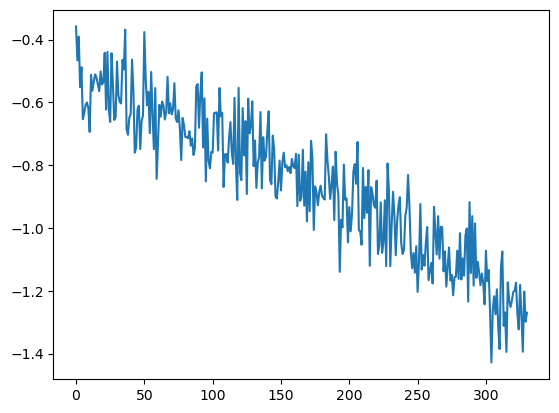

[0.01233023 0.00913397 0.16004916 0.11239151 0.05908418 0.03122016
 0.8527149  0.47950872]
0.0028294152789157183
(-1.2379168094114041+0j)
[0.01233241 0.00914809 0.16003302 0.11256538 0.05907602 0.03126729
 0.85233769 0.48014116]
0.0030176678644786544
(-1.3889539407086746+0j)
[0.01233481 0.00916309 0.16003078 0.1127595  0.05906198 0.03131442
 0.85193453 0.48080971]
0.002870533217997141
(-1.197713486387144+0j)
[0.01233817 0.00917812 0.16003048 0.1129457  0.05905321 0.0313615
 0.85155001 0.4814445 ]
0.0027345874513459113
(-1.1729813616824503+0j)
[0.01234074 0.00919207 0.16002426 0.11311995 0.05904388 0.0314062
 0.85118276 0.4820526 ]
0.002973755220052305
(-1.4657936631145863+0j)
Epoch 335, Hamiltonian Expectation Value: (-1.4657936631145863+0j)


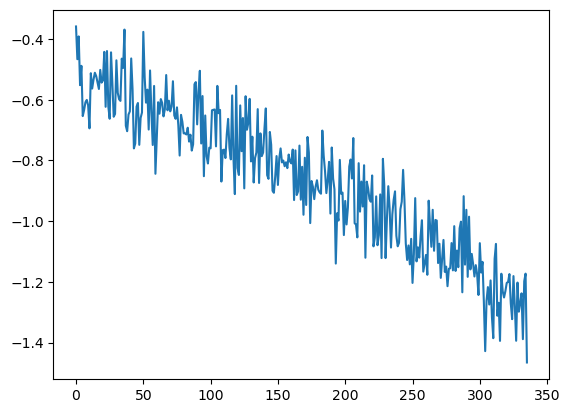

[0.01234334 0.0092071  0.16002294 0.11331272 0.05903057 0.03145313
 0.8507825  0.48271212]
0.0030479781848655844
(-1.3019675886910673+0j)
[0.01234637 0.00922272 0.16003256 0.11351654 0.05901461 0.0314998
 0.85037152 0.48338329]
0.0029325629780405996
(-1.229201154736834+0j)
[0.01234911 0.00923775 0.16002667 0.11370472 0.059004   0.03154759
 0.84997529 0.48403528]
0.0029008563806396078
(-1.2991045660114071+0j)
[0.0123504  0.0092517  0.16001162 0.11388563 0.05898983 0.03159348
 0.84958188 0.4846864 ]
0.0027695332251159136
(-1.2383548648680605+0j)
[0.01235206 0.00926528 0.16000933 0.11406541 0.05897385 0.03163575
 0.84920561 0.48530277]
0.0027103156954286153
(-1.3749166044160188+0j)
Epoch 340, Hamiltonian Expectation Value: (-1.3749166044160188+0j)


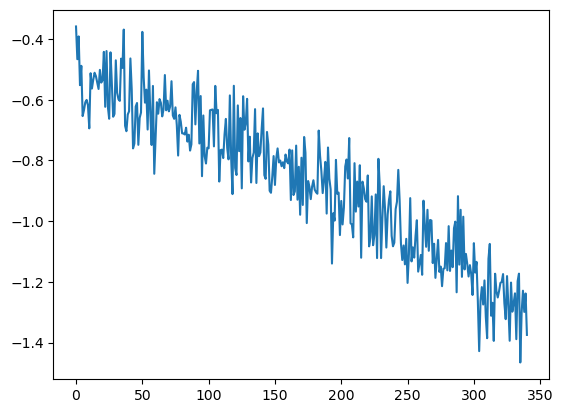

[0.01235547 0.00927975 0.16001373 0.11424567 0.05896448 0.03167991
 0.84883722 0.48590093]
0.0029392942579709834
(-1.4258966122947065+0j)
[0.01235833 0.00929502 0.16000597 0.11443425 0.05895479 0.03172863
 0.84843665 0.48655589]
0.002607285457919026
(-1.3103415857432403+0j)
[0.012362   0.0093093  0.16000229 0.11460357 0.05895057 0.03177381
 0.84808143 0.48713341]
0.0029008079144379655
(-1.4490429304190389+0j)
[0.01236334 0.00932339 0.15998712 0.11478572 0.05893641 0.03181996
 0.84768427 0.48778474]
0.0028241264553797983
(-1.4739492104160694+0j)
[0.01236527 0.00933755 0.15997657 0.11496592 0.05892403 0.03186554
 0.84729643 0.48841738]
0.0027115395024890827
(-1.228175370355216+0j)
Epoch 345, Hamiltonian Expectation Value: (-1.228175370355216+0j)


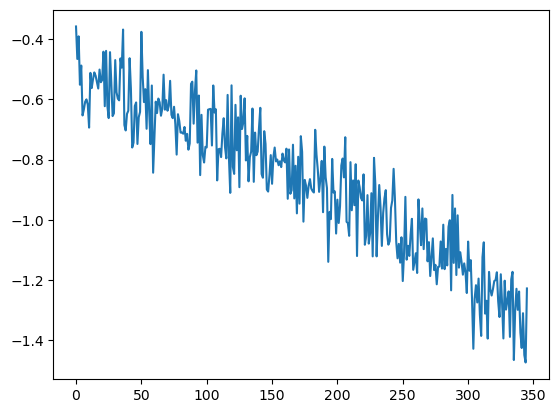

[0.01236758 0.00935136 0.15997987 0.11514668 0.05890934 0.03190738
 0.84692379 0.48901839]
0.0024430758210887828
(-1.2677703139321148+0j)
[0.01237081 0.00936449 0.15999963 0.11531877 0.05889548 0.03194409
 0.84658891 0.48954988]
0.002897464901781643
(-1.4020226650666348+0j)
[0.01237454 0.0093803  0.16000143 0.11551189 0.05888639 0.03199257
 0.84618874 0.49019273]
0.0026638328012907387
(-1.399219100031626+0j)
[0.01237556 0.0093932  0.15998092 0.11567647 0.0588745  0.03203595
 0.8458202  0.49079462]
0.003066444461813142
(-1.2553983623725151+0j)
[0.01237677 0.00940809 0.15996339 0.11586978 0.05885862 0.03208471
 0.84539501 0.49148522]
0.0026144748628484514
(-1.3072861851170763+0j)
Epoch 350, Hamiltonian Expectation Value: (-1.3072861851170763+0j)


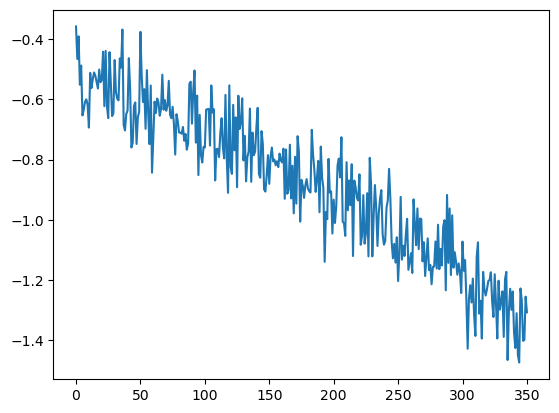

[0.01237708 0.0094203  0.15994228 0.11603096 0.0588438  0.03212585
 0.84503168 0.49207738]
0.0027782353615191033
(-1.3958019706605376+0j)
[0.01238093 0.00943571 0.15993772 0.11621339 0.05883852 0.0321743
 0.84464556 0.49269541]
0.002800790676294127
(-1.3218652847761063+0j)
[0.01238373 0.0094505  0.15993709 0.11639989 0.05882642 0.03221972
 0.84425505 0.49331863]
0.0026555344335686313
(-1.3488411185301323+0j)
[0.01238655 0.00946471 0.15992526 0.11657037 0.05881989 0.03226562
 0.84388475 0.49391288]
0.002828243832898036
(-1.4384673764398959+0j)
[0.01238927 0.00947969 0.15991501 0.11675368 0.05881055 0.03231344
 0.84348877 0.49454652]
0.0028072870833231603
(-1.4766345310993705+0j)
Epoch 355, Hamiltonian Expectation Value: (-1.4766345310993705+0j)


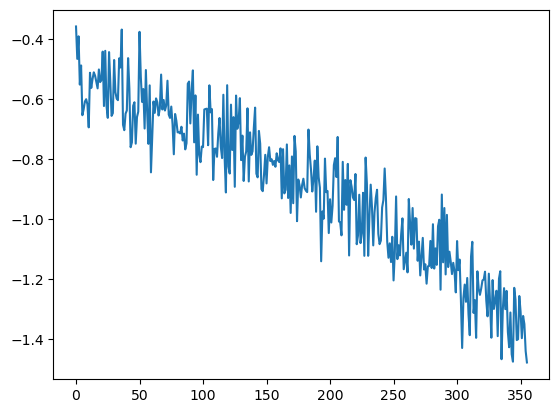

[0.01239087 0.00949372 0.15990472 0.11693557 0.05879594 0.03235805
 0.84309503 0.49517638]
0.002728194139032189
(-1.327921299316936+0j)
[0.0123936  0.00950812 0.15990922 0.11712103 0.05878203 0.03240106
 0.84271196 0.49578129]
0.0026452027120938753
(-1.2782531946400606+0j)
[0.01239437 0.00952096 0.15988858 0.11728636 0.05876853 0.03244388
 0.84233896 0.49638091]
0.0029696960592676385
(-1.4981429373421167+0j)
[0.01239614 0.00953588 0.1598836  0.11748291 0.05875108 0.03248996
 0.84192022 0.49704472]
0.0030263723666785103
(-1.370568790255362+0j)
[0.01239718 0.00955066 0.15986911 0.117678   0.05873286 0.0325373
 0.84149147 0.49772757]
0.002578594800990895
(-1.4875339594963828+0j)
Epoch 360, Hamiltonian Expectation Value: (-1.4875339594963828+0j)


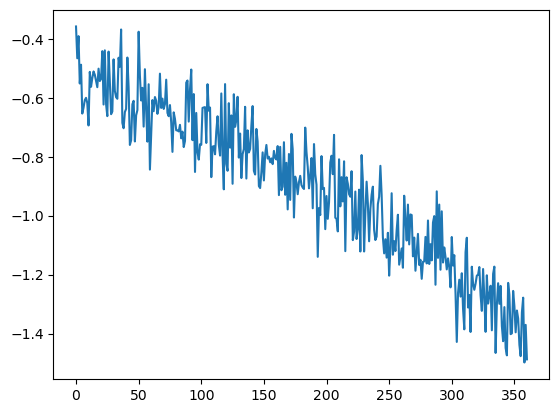

[0.01239727 0.00956271 0.15984944 0.11783981 0.05871619 0.03257726
 0.84112579 0.49831249]
0.0027688872445706743
(-1.4701596895216724+0j)
[0.01240036 0.0095777  0.15985334 0.11802911 0.0587035  0.03262206
 0.84073277 0.49892751]
0.002554360821924617
(-1.3938988612812058+0j)
[0.01240112 0.0095901  0.15984179 0.1181947  0.05868723 0.03266148
 0.84036959 0.4995026 ]
0.002776870734614003
(-1.461271716605688+0j)
[0.01240339 0.00960471 0.15983118 0.11837668 0.05867562 0.03270782
 0.83997272 0.50012805]
0.002967778174584614
(-1.367911509257083+0j)
[0.01240621 0.00962062 0.15981087 0.11856578 0.05866861 0.03276015
 0.83954966 0.50079667]
0.002811668297779212
(-1.3818773947428464+0j)
Epoch 365, Hamiltonian Expectation Value: (-1.3818773947428464+0j)


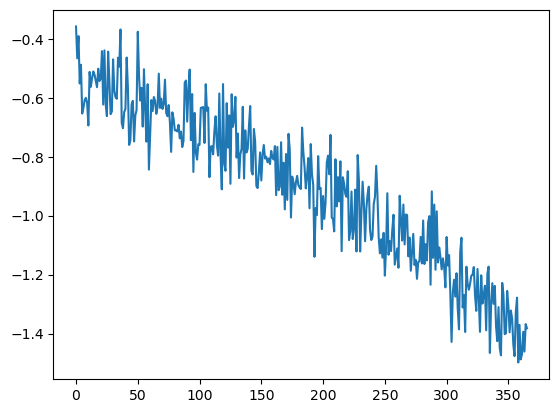

[0.01240749 0.00963467 0.15979679 0.11874826 0.05865312 0.03280508
 0.83914697 0.50143102]
0.0027970856635731556
(-1.2817162640391493+0j)
[0.01240823 0.00964831 0.15978027 0.11892839 0.05863599 0.03284907
 0.83874532 0.50206403]
0.003035179230278663
(-1.4629323882038583+0j)
[0.01241405 0.00966657 0.15978879 0.11913969 0.05863202 0.03290327
 0.83831196 0.50273098]
0.002771082828186641
(-1.5273228369239091+0j)
[0.01241572 0.00968089 0.15976263 0.11931289 0.05862308 0.03295155
 0.83791297 0.50336055]
0.002714973782079939
(-1.6199364349666687+0j)
[0.01241825 0.00969538 0.15976396 0.119499   0.05860864 0.03299482
 0.83752183 0.50396508]
0.0026188940923138845
(-1.5227261286737959+0j)
Epoch 370, Hamiltonian Expectation Value: (-1.5227261286737959+0j)


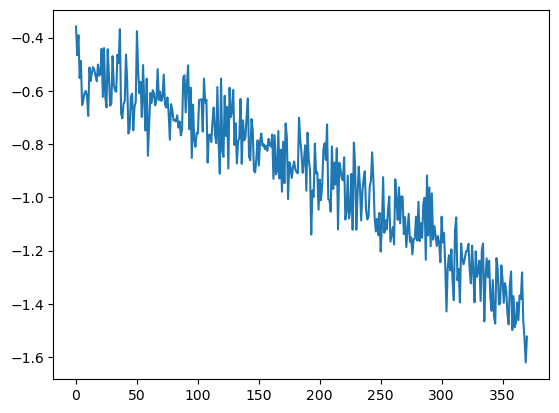

[0.01242006 0.00970905 0.15974931 0.11966943 0.05859751 0.03303876
 0.83714293 0.50455659]
0.002594090972334701
(-1.590409837501903+0j)
[0.01242265 0.00972308 0.15974459 0.11984431 0.05858666 0.03308192
 0.83676774 0.50513669]
0.0027313739084775836
(-1.4353064168729075+0j)
[0.01242464 0.0097374  0.15973183 0.120024   0.05857456 0.03312735
 0.83637172 0.50575166]
0.0026530488043637907
(-1.4333964768457412+0j)
[0.0124284  0.00975265 0.15972463 0.12020179 0.05856961 0.03317502
 0.83598691 0.50634465]
0.002932060163773331
(-1.5090270997602186+0j)
[0.01243066 0.0097682  0.1597092  0.12039421 0.05855766 0.03322462
 0.83556004 0.50700573]
0.002830161808918572
(-1.4181719269926405+0j)
Epoch 375, Hamiltonian Expectation Value: (-1.4181719269926405+0j)


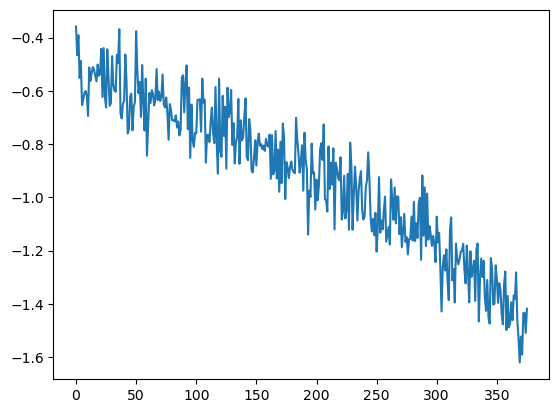

[0.01243267 0.00978307 0.1596982  0.12058253 0.05854371 0.03327113
 0.83514686 0.50764303]
0.002809258411899072
(-1.497635159033184+0j)
[0.01243326 0.00979673 0.15969106 0.12077109 0.05852168 0.03331271
 0.83473719 0.50827341]
0.0027823358534016726
(-1.3837467997031994+0j)
[0.01243467 0.00981107 0.1596734  0.12095259 0.05850759 0.03335877
 0.83432888 0.5089041 ]
0.002594595926411232
(-1.6809017896966127+0j)
[0.01243885 0.00982642 0.15966766 0.1211282  0.05850448 0.03340638
 0.83395007 0.50948153]
0.0025467929283698627
(-1.3495802413586675+0j)
[0.01244046 0.00983973 0.159655   0.12129685 0.05849186 0.0334484
 0.83357582 0.51005591]
0.002574297138831589
(-1.51884017311739+0j)
Epoch 380, Hamiltonian Expectation Value: (-1.51884017311739+0j)


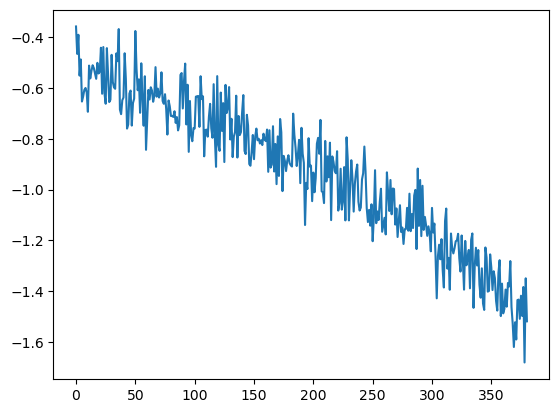

[0.01244125 0.00985263 0.15963601 0.1214636  0.05847724 0.0334902
 0.83319649 0.51064029]
0.0029170566820090134
(-1.5178135551984018+0j)
[0.01244583 0.00986981 0.15963031 0.12166221 0.05847282 0.03354312
 0.83276917 0.51128804]
0.0029236782630128783
(-1.35520283886323+0j)
[0.01244869 0.00988575 0.15963305 0.12186686 0.05845658 0.03358986
 0.83233823 0.51193815]
0.0029621334302164883
(-1.479211705523852+0j)
[0.01244953 0.0099005  0.15962471 0.12206736 0.05843421 0.03363464
 0.83189975 0.51260458]
0.0028554120860937015
(-1.6380120008091845+0j)
[0.01245193 0.00991598 0.15961936 0.1222633  0.05841911 0.03368153
 0.83147505 0.5132465 ]
0.0027878873057271426
(-1.429690839340479+0j)
Epoch 385, Hamiltonian Expectation Value: (-1.429690839340479+0j)


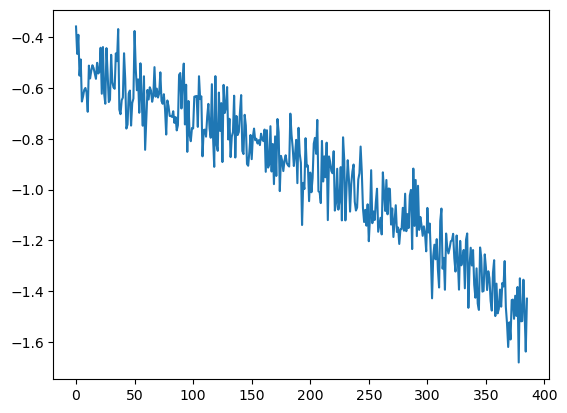

[0.01245452 0.00993134 0.15960544 0.1224496  0.05840882 0.03372994
 0.83106003 0.51387584]
0.00309322893119522
(-1.4079057478126051+0j)
[0.01245606 0.00994745 0.1595845  0.12265293 0.05839288 0.03378143
 0.83059893 0.51457696]
0.0029182078827251203
(-1.4831758942020037+0j)
[0.01245802 0.00996307 0.15955791 0.1228408  0.05838282 0.03383294
 0.8301633  0.51524035]
0.003043703152183337
(-1.5578987702524698+0j)
[0.01246018 0.00997941 0.1595442  0.12304593 0.05836753 0.03388375
 0.82970756 0.5159273 ]
0.002997455460318018
(-1.5263401379365873+0j)
[0.01246197 0.00999517 0.1595355  0.12325092 0.05834909 0.03393164
 0.8292584  0.51660136]
0.0029108955309526865
(-1.442435336156745+0j)
Epoch 390, Hamiltonian Expectation Value: (-1.442435336156745+0j)


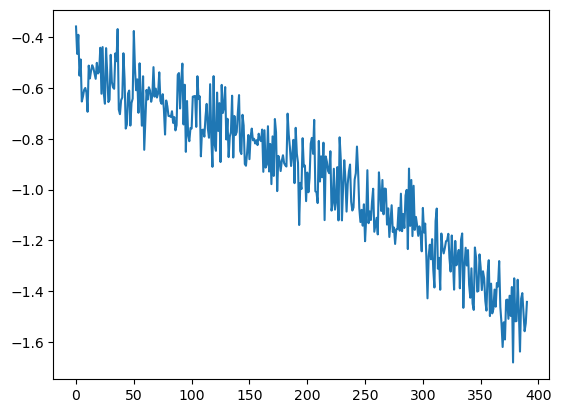

[0.0124636  0.01001049 0.15951727 0.12344438 0.05833423 0.03398017
 0.82882128 0.51726002]
0.0030237192310127417
(-1.3259209759410997+0j)
[0.01246259 0.01002444 0.1594897  0.12363913 0.05830887 0.03402562
 0.82836627 0.51795005]
0.0026035079516104113
(-1.4046113526064763+0j)
[0.01246469 0.01003862 0.15948461 0.12381961 0.05829428 0.03406818
 0.82797339 0.51853488]
0.002708915924353789
(-1.4563785616894085+0j)
[0.01246607 0.01005292 0.15945642 0.12399322 0.0582837  0.03411577
 0.82756399 0.51915299]
0.0031476592886127966
(-1.5141425210337747+0j)
[0.01246735 0.01006933 0.15943175 0.12420053 0.05826666 0.03416853
 0.82708616 0.51987009]
0.0028998171231462925
(-1.650935493042883+0j)
Epoch 395, Hamiltonian Expectation Value: (-1.650935493042883+0j)


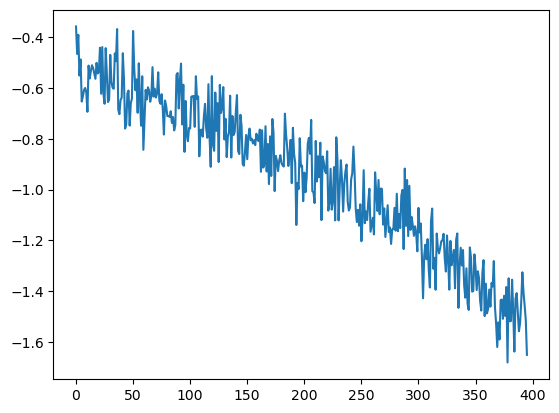

[0.01246805 0.01008402 0.15941795 0.12439697 0.05824528 0.03421368
 0.82664532 0.52052723]
0.003026066668778196
(-1.6831766002209314+0j)
[0.01246953 0.01010006 0.1593846  0.12459052 0.05823364 0.03426728
 0.82618524 0.52121857]
0.003018834206225342
(-1.4566684051841916+0j)
[0.01247054 0.01011568 0.15935808 0.12478829 0.0582171  0.0343179
 0.82572452 0.52190719]
0.00275187980780634
(-1.4678270844248407+0j)
[0.01247279 0.01013086 0.15935109 0.12497952 0.05820204 0.03436343
 0.82530507 0.52252498]
0.002604537859623073
(-1.4979069735427317+0j)
[0.01247341 0.01014414 0.15933334 0.12515368 0.05818464 0.03440522
 0.82490664 0.52311644]
0.0028433934021240195
(-1.5263150449110823+0j)
Epoch 400, Hamiltonian Expectation Value: (-1.5263150449110823+0j)


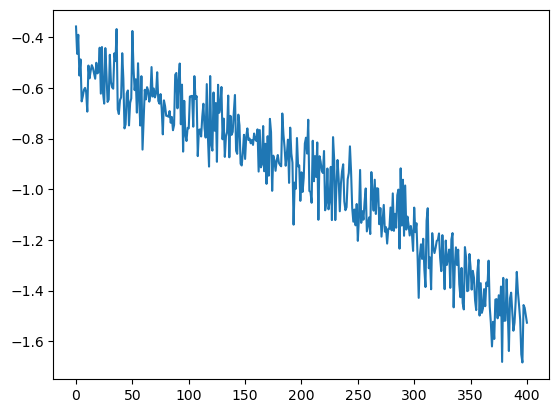

[0.01247591 0.0101601  0.15930498 0.12533819 0.05817771 0.03445777
 0.82447253 0.52376183]
0.002834022464294584
(-1.7361443816848028+0j)
[0.01247846 0.01017591 0.15930184 0.12553833 0.05816172 0.03450426
 0.82403882 0.52439535]
0.00303931834055309
(-1.5245281411157627+0j)
[0.01248024 0.01019222 0.15928491 0.12574499 0.05814493 0.03455484
 0.82357189 0.52508223]
0.002698747382515417
(-1.5147947692111208+0j)
[0.01248    0.01020534 0.15926863 0.12592712 0.05812157 0.03459528
 0.82315611 0.52569482]
0.0028864295828869777
(-1.5482779315939905+0j)
[0.01248256 0.01022145 0.15926789 0.12613339 0.05810394 0.03464198
 0.82271138 0.52633988]
0.0031500634477752932
(-1.601782987637537+0j)
Epoch 405, Hamiltonian Expectation Value: (-1.601782987637537+0j)


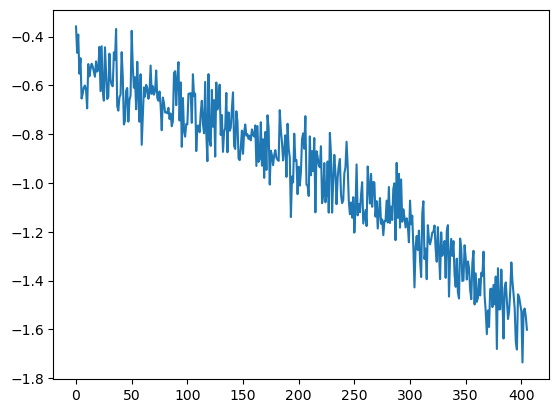

[0.01248315 0.01023758 0.15924139 0.12634269 0.05808339 0.03469343
 0.82222323 0.52705855]
0.0030426782148041598
(-1.4287444731492616+0j)
[0.0124837  0.01025305 0.15922503 0.12655064 0.05806009 0.0347407
 0.82175196 0.52774727]
0.0028437497914083473
(-1.6721072431006236+0j)
[0.0124836  0.01026712 0.15920389 0.12674148 0.05803739 0.03478476
 0.82130986 0.52839499]
0.002817383221937796
(-1.5521462340735244+0j)
[0.01248685 0.01028367 0.15918335 0.12693131 0.05803079 0.03483726
 0.8208728  0.52903125]
0.003131651876727002
(-1.6668478027016769+0j)
[0.01248747 0.01029987 0.15915094 0.12713665 0.05801258 0.03489003
 0.82038423 0.52974728]
0.0028335083631914077
(-1.5995106028133694+0j)
Epoch 410, Hamiltonian Expectation Value: (-1.5995106028133694+0j)


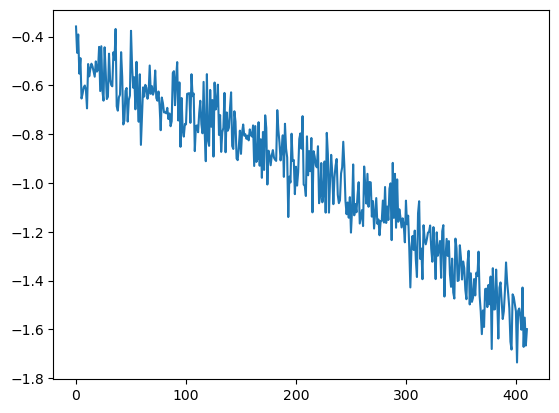

[0.01248764 0.01031424 0.15912649 0.12732559 0.05799219 0.03493559
 0.81994088 0.53039418]
0.0026133897278439898
(-1.7215124335017666+0j)
[0.01248802 0.01032768 0.1591016  0.1274988  0.05797532 0.0349788
 0.81953112 0.53099173]
0.003021034983558364
(-1.700765476637206+0j)
[0.01248846 0.01034332 0.15905949 0.12769036 0.05796078 0.03503199
 0.81905743 0.53168651]
0.003017970966436077
(-1.6612165827181835+0j)
[0.01248694 0.01035737 0.1590212  0.12788376 0.05793541 0.03507883
 0.81858347 0.53238038]
0.003073775190926848
(-1.5768655673596346+0j)
[0.01248657 0.01037259 0.15898907 0.12808608 0.05791257 0.03512809
 0.81809928 0.53308408]
0.002848582149366171
(-1.5387046695385413+0j)
Epoch 415, Hamiltonian Expectation Value: (-1.5387046695385413+0j)


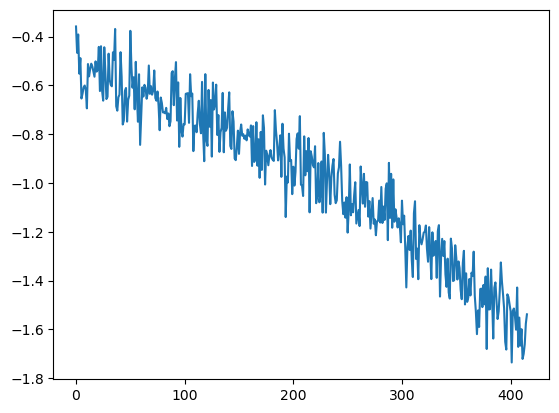

[0.01248578 0.01038639 0.1589534  0.1282698  0.05789144 0.03517394
 0.81764994 0.53373856]
0.003203361705006215
(-1.753621732779543+0j)
[0.01248597 0.01040261 0.15893159 0.12848866 0.05786602 0.03522382
 0.81714453 0.53446509]
0.002874475023125088
(-1.4603015252296452+0j)
[0.01248436 0.01041593 0.15889351 0.12867271 0.05784143 0.03526838
 0.81668963 0.53512652]
0.00296663518394622
(-1.596455558813553+0j)
[0.01248473 0.01043124 0.15886713 0.12887231 0.05782089 0.03531678
 0.81621878 0.53580301]
0.002927347387733456
(-1.6513139076408618+0j)
[0.01248509 0.01044643 0.15883685 0.12906686 0.05780198 0.03536571
 0.81575236 0.53647356]
0.0028174109282893016
(-1.6220300306416742+0j)
Epoch 420, Hamiltonian Expectation Value: (-1.6220300306416742+0j)


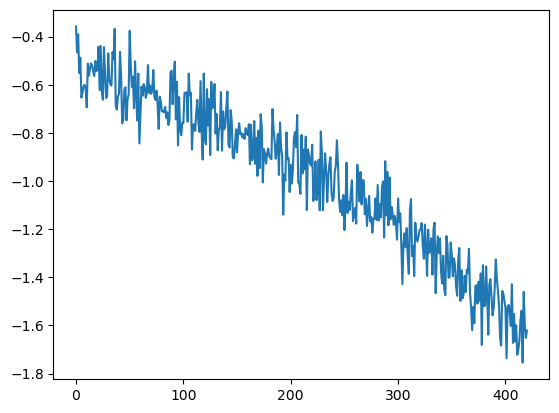

[0.01248588 0.01046125 0.15882436 0.12926484 0.05777981 0.03540975
 0.81530412 0.5371098 ]
0.002698758666053313
(-1.564946986927993+0j)
[0.0124853  0.01047444 0.15880369 0.12944856 0.05775544 0.03545038
 0.81487444 0.53772306]
0.002932050636547409
(-1.6595499240546245+0j)
[0.01248496 0.01048909 0.15877298 0.12964356 0.05773319 0.03549738
 0.81440586 0.53839364]
0.0027938802776915415
(-1.5386508445592684+0j)
[0.01248737 0.01050511 0.15876109 0.1298414  0.0577187  0.03554532
 0.81395973 0.53902177]
0.0029728814792987436
(-1.7179936664397313+0j)
[0.01248793 0.01052066 0.15874179 0.13004757 0.05769592 0.0355926
 0.81348259 0.53969664]
0.003138072008079393
(-1.5635759364883297+0j)
Epoch 425, Hamiltonian Expectation Value: (-1.5635759364883297+0j)


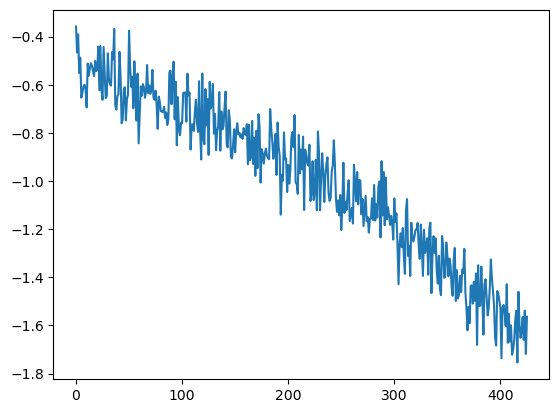

[0.01248711 0.01053604 0.15870797 0.13025625 0.05767014 0.03564189
 0.81297874 0.54041422]
0.002576634384965625
(-1.7277564017827665+0j)
[0.01248924 0.01055084 0.15869596 0.13043887 0.0576564  0.03568622
 0.81256417 0.54099509]
0.0029518009175072187
(-1.5969945878002147+0j)
[0.01249063 0.01056717 0.15866517 0.13063711 0.05764175 0.03573859
 0.8120875  0.54166937]
0.0029451281964433225
(-1.5499408703397206+0j)
[0.01249069 0.0105824  0.15863163 0.13083308 0.0576218  0.03578778
 0.81161064 0.54234476]
0.003131567740938669
(-1.6725476892718467+0j)
[0.01249247 0.01059993 0.15860774 0.13104985 0.05760435 0.03584193
 0.81110315 0.54305606]
0.0028149231621304883
(-1.5832577360724123+0j)
Epoch 430, Hamiltonian Expectation Value: (-1.5832577360724123+0j)


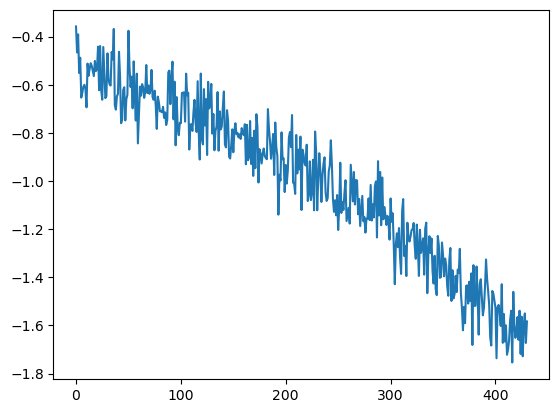

[0.01249433 0.01061574 0.1585971  0.1312518  0.05758605 0.03588833
 0.81064803 0.54368812]
0.00294841630212477
(-1.6635793595507593+0j)
[0.01249377 0.01063057 0.15855979 0.13144609 0.0575643  0.03593683
 0.81016802 0.54436595]
0.0028830563097151586
(-1.7127540421452434+0j)
[0.01249547 0.01064679 0.15853832 0.13164673 0.05754826 0.03598664
 0.80969919 0.54501892]
0.0027846622348403436
(-1.6320154516157503+0j)
[0.01249825 0.01066324 0.15853045 0.13184911 0.05753343 0.03603452
 0.80924717 0.5456413 ]
0.0028556698600280574
(-1.5865153222533424+0j)
[0.01249893 0.01067861 0.15849903 0.1320415  0.05751629 0.03608367
 0.8087804  0.54629383]
0.0029875019632192553
(-1.6551198137377439+0j)
Epoch 435, Hamiltonian Expectation Value: (-1.6551198137377439+0j)


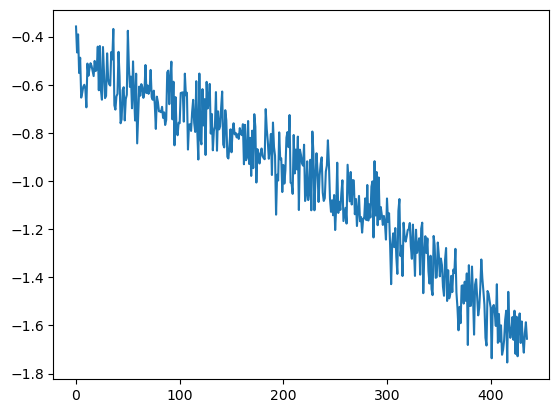

[0.0124998  0.01069473 0.15847865 0.13225123 0.05749453 0.03613229
 0.80829226 0.54696981]
0.0027297795419244093
(-1.6319000710710414+0j)
[0.01250324 0.01071146 0.15847143 0.13245056 0.05748309 0.03618102
 0.80784796 0.54757729]
0.002886052742030321
(-1.662072441317267+0j)
[0.01250554 0.01072823 0.15846111 0.1326598  0.0574653  0.03622971
 0.80737559 0.5482242 ]
0.003055395690931585
(-1.5663325065349285+0j)
[0.01250514 0.01074395 0.15842117 0.1328623  0.05744359 0.03628094
 0.80687176 0.54892661]
0.0027696837372909715
(-1.5858017075814703+0j)
[0.01250543 0.01075875 0.15839037 0.13305003 0.05742478 0.036328
 0.80641335 0.54956185]
0.0029304338831525776
(-1.7473417696015652+0j)
Epoch 440, Hamiltonian Expectation Value: (-1.7473417696015652+0j)


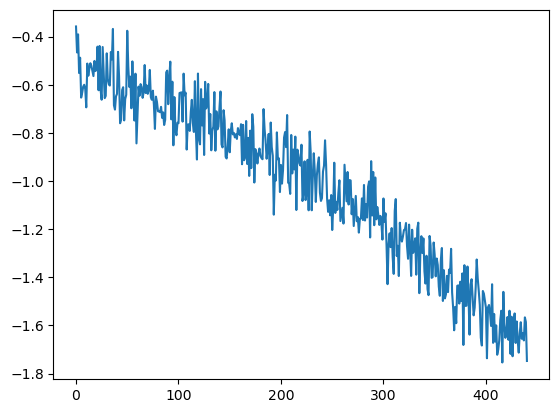

[0.0125039  0.01077285 0.15835309 0.13324469 0.05739812 0.03637346
 0.8059298  0.55023389]
0.0030559644049143976
(-1.8252576931908824+0j)
[0.01250562 0.01079009 0.158336   0.13346356 0.05737801 0.03642457
 0.80542532 0.55092235]
0.0031466457429161795
(-1.6139376455366956+0j)
[0.01250522 0.01080626 0.15830329 0.13367874 0.0573524  0.03647506
 0.80490388 0.55164021]
0.002893590804277847
(-1.8112756953243236+0j)
[0.01250594 0.01082193 0.15828226 0.13388317 0.05733062 0.03652216
 0.80442402 0.55229506]
0.003108785456226641
(-1.9237719164512537+0j)
[0.01250507 0.01083768 0.15824009 0.13408966 0.05730641 0.03657339
 0.80390577 0.55301002]
0.0028344143861265703
(-1.8178548627308464+0j)
Epoch 445, Hamiltonian Expectation Value: (-1.8178548627308464+0j)


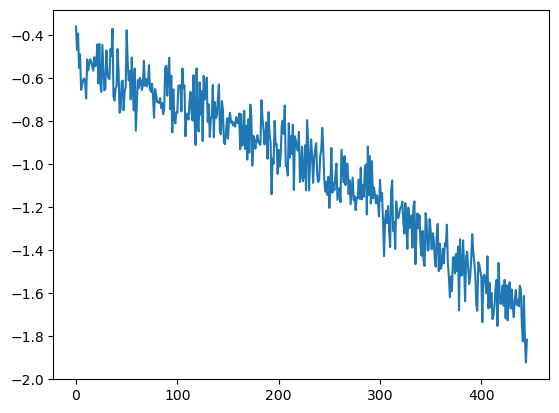

[0.01250642 0.01085365 0.15822209 0.13429243 0.05728695 0.03662086
 0.80343356 0.55365037]
0.0030650371601613855
(-1.7575561232228354+0j)
[0.0125049  0.0108687  0.15817185 0.13449024 0.05726306 0.03667164
 0.8029216  0.55435781]
0.0029382725363428985
(-1.695751509873714+0j)
[0.01250337 0.01088302 0.15813106 0.13468507 0.05723711 0.0367182
 0.80242993 0.555033  ]
0.0028248333359769976
(-1.5341869345520605+0j)
[0.01250499 0.01089924 0.15810602 0.13488316 0.0572214  0.03676804
 0.80195664 0.55567366]
0.00297531817427584
(-1.780352722884913+0j)
[0.01250554 0.01091549 0.15807352 0.13508781 0.05720161 0.03681896
 0.80145715 0.55635177]
0.0031242610244241295
(-1.8452942748777306+0j)
Epoch 450, Hamiltonian Expectation Value: (-1.8452942748777306+0j)


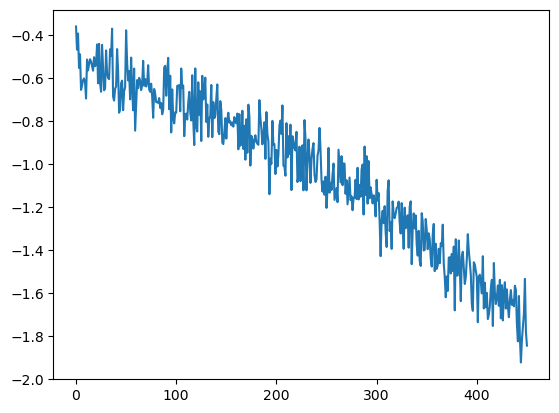

[0.0125051  0.0109317  0.15803989 0.13530294 0.05717576 0.03686931
 0.800932   0.55706386]
0.002827081019257314
(-1.6211372699715128+0j)
[0.01250547 0.01094701 0.15800655 0.13549607 0.05715713 0.03691773
 0.8004566  0.55770772]
0.003002990635352628
(-1.6294253343988983+0j)
[0.01250573 0.01096322 0.15797159 0.1357019  0.05713628 0.03696882
 0.79994922 0.55839357]
0.0027003863270334137
(-1.8001344779374615+0j)
[0.01250867 0.01097989 0.15796065 0.13590118 0.05712276 0.03701708
 0.79949441 0.55899705]
0.002907232407797755
(-1.8504075767675436+0j)
[0.01250884 0.01099556 0.15792487 0.13609956 0.0571028  0.03706678
 0.79900201 0.55966096]
0.003169302511769719
(-1.6822630694614542+0j)
Epoch 455, Hamiltonian Expectation Value: (-1.6822630694614542+0j)


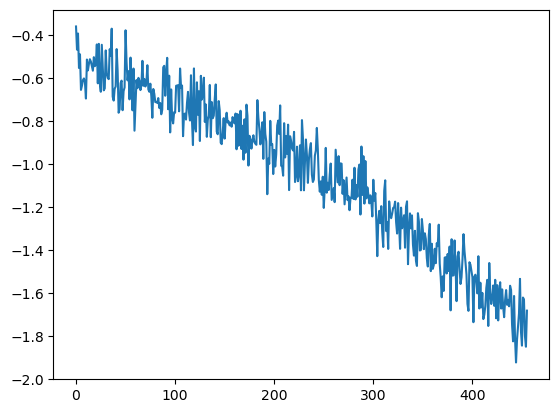

[0.01250947 0.01101296 0.15789405 0.1363218  0.05708011 0.03712006
 0.79846458 0.56038054]
0.0029728202253380557
(-1.7050978828454968+0j)
[0.01251025 0.01102948 0.15786781 0.13653248 0.05705855 0.03717001
 0.79795886 0.56105512]
0.0029126500313058634
(-1.7972079411810484+0j)
[0.01251049 0.01104532 0.15783332 0.13673305 0.05703805 0.03721975
 0.797462   0.56172049]
0.002936186226465558
(-1.7059748637230943+0j)
[0.012509   0.01105995 0.15778679 0.13692669 0.05701354 0.03726796
 0.79696074 0.56239643]
0.0029060422859199303
(-1.7770402587509064+0j)
[0.01250853 0.01107526 0.1577504  0.13712578 0.05699032 0.03731621
 0.79646305 0.56306165]
0.0028397782967379587
(-1.7611809022968548+0j)
Epoch 460, Hamiltonian Expectation Value: (-1.7611809022968548+0j)


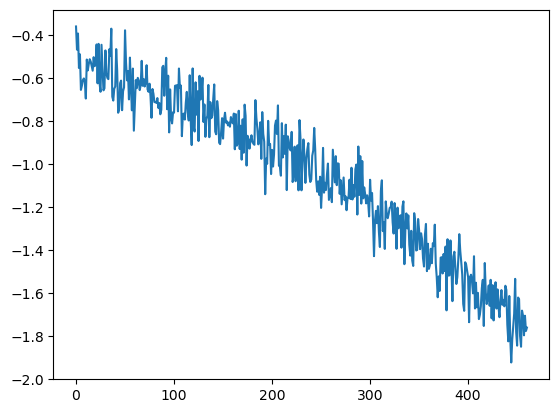

[0.01250738 0.01108964 0.15770703 0.13731474 0.05696731 0.03736318
 0.79597686 0.56371384]
0.002882679098691019
(-1.7124182006067779+0j)
[0.01250539 0.01110361 0.15765716 0.13750227 0.05694212 0.03741003
 0.79548237 0.5643789 ]
0.0028660629196614607
(-1.8281895281675025+0j)
[0.01250461 0.01111852 0.15761438 0.13769433 0.05692015 0.03745843
 0.79498926 0.56503719]
0.0030612742258663518
(-1.730685452804152+0j)
[0.01250408 0.01113464 0.15757304 0.13790282 0.05689648 0.0375097
 0.79446278 0.56573661]
0.0030325797636549393
(-1.856928028099107+0j)
[0.01250333 0.01115042 0.15753711 0.13811302 0.05687003 0.03755857
 0.79394002 0.56642792]
0.0029346086696552167
(-1.7026968891950456+0j)
Epoch 465, Hamiltonian Expectation Value: (-1.7026968891950456+0j)


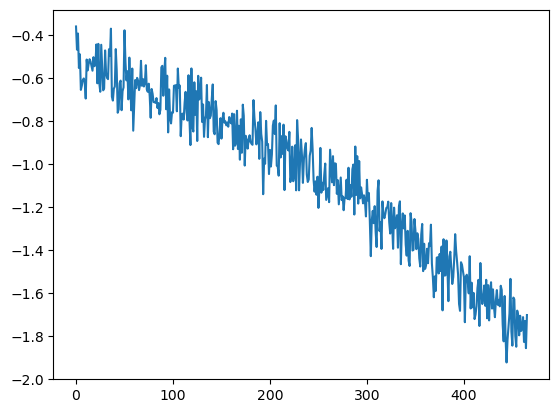

[0.012503   0.01116612 0.15749155 0.13830918 0.05685025 0.03760984
 0.79343352 0.56710032]
0.002865925203094995
(-2.0020906629174693+0j)
[0.01250251 0.01118124 0.1574562  0.13850742 0.05682668 0.03765697
 0.79293794 0.56775348]
0.0029967172942346135
(-1.8310033442595002+0j)
[0.01250228 0.01119727 0.15742672 0.13872016 0.05680061 0.0377051
 0.79241958 0.56843213]
0.0028630125438444654
(-1.7927544187934852+0j)
[0.01250314 0.01121354 0.15740299 0.13892683 0.05677895 0.03775307
 0.79192399 0.56907716]
0.0032240257786490434
(-1.597937222494737+0j)
[0.01250328 0.0112313  0.15735775 0.13914708 0.05675741 0.03780969
 0.79136325 0.56981347]
0.0030368383447196548
(-1.8092104912754954+0j)
Epoch 470, Hamiltonian Expectation Value: (-1.8092104912754954+0j)


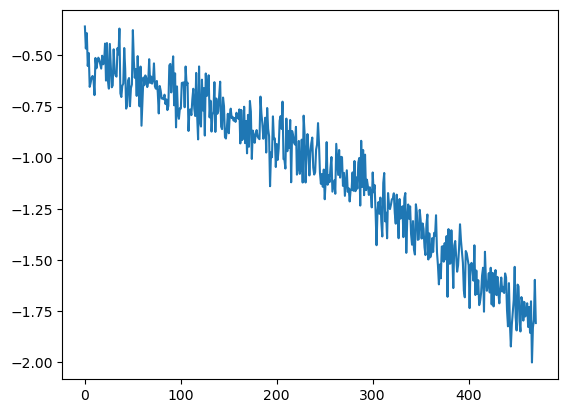

[0.01250353 0.01124802 0.15732964 0.13936494 0.05673238 0.03785942
 0.79083541 0.57049925]
0.003136912780855774
(-1.8391900898048283+0j)
[0.0125023  0.01126425 0.15727545 0.13957212 0.05670857 0.0379132
 0.79028798 0.57122018]
0.002845353310315893
(-1.6733625562673704+0j)
[0.0125023  0.01127988 0.15724    0.1397705  0.05668705 0.0379617
 0.78979    0.57186842]
0.0028281668356603877
(-1.8187761481790898+0j)
[0.0125006  0.01129401 0.15719    0.13995664 0.05666315 0.03800865
 0.78929525 0.57251836]
0.002980913043946546
(-1.7174725674623625+0j)
[0.01250079 0.01131047 0.15715803 0.14016848 0.05663967 0.03805841
 0.78877372 0.57319235]
0.002998434933624355
(-1.9403662552127845+0j)
Epoch 475, Hamiltonian Expectation Value: (-1.9403662552127845+0j)


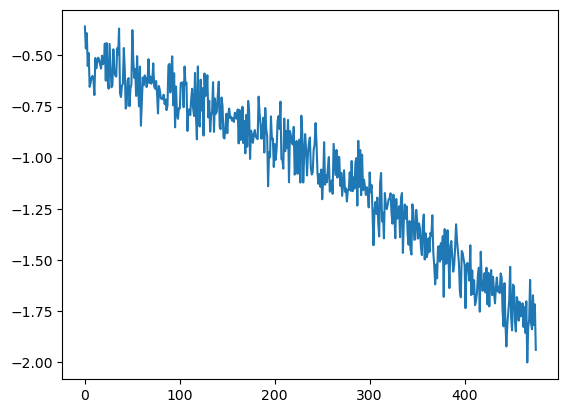

[0.01250003 0.01132628 0.15711875 0.14037654 0.05661411 0.03810759
 0.78824769 0.57387439]
0.003019234404323606
(-1.8523181320483812+0j)
[0.01249956 0.01134252 0.15708216 0.14058844 0.05658846 0.03815726
 0.78771696 0.57455979]
0.0027634925159441743
(-2.031535777806009+0j)
[0.01250023 0.01135825 0.15705013 0.14078394 0.0565697  0.03820543
 0.78723123 0.57518439]
0.0029156364610898487
(-1.8291939734886473+0j)
[0.01249978 0.01137401 0.15701064 0.14098631 0.05654634 0.03825461
 0.78671635 0.57584841]
0.0033657744381302094
(-1.9853080072167475+0j)
[0.01249903 0.01139206 0.15696435 0.14121969 0.05651849 0.03831097
 0.78612099 0.57661504]
0.0031307378222886996
(-1.8503500155932837+0j)
Epoch 480, Hamiltonian Expectation Value: (-1.8503500155932837+0j)


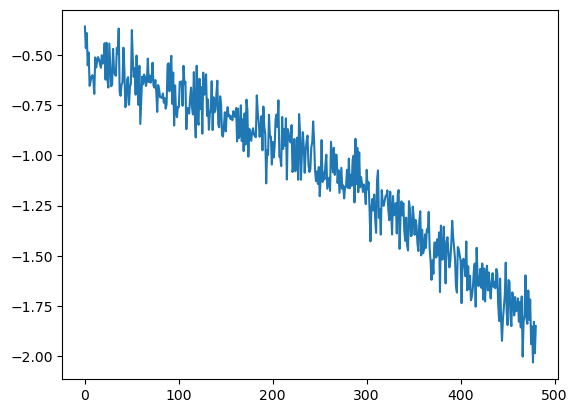

[0.01249874 0.01140914 0.15692561 0.14144018 0.05649287 0.0383633
 0.78556682 0.57732506]
0.002954798280143646
(-1.7419587425878211+0j)
[0.01249999 0.0114266  0.15688588 0.14164622 0.05647684 0.03841797
 0.78504368 0.57799411]
0.0029161711661731425
(-1.8011349460370054+0j)
[0.01250098 0.01144365 0.15685442 0.14185572 0.05645689 0.0384693
 0.78452531 0.57865291]
0.0027745945414020066
(-1.885905607917301+0j)
[0.01250048 0.01145858 0.15682365 0.14205419 0.05643159 0.03851393
 0.78403202 0.57928001]
0.0029563870469074423
(-1.810349270565098+0j)
[0.01249821 0.01147313 0.15677763 0.14225574 0.05640118 0.03855999
 0.78350478 0.57995564]
0.0029330624454392577
(-1.9587410162829804+0j)
Epoch 485, Hamiltonian Expectation Value: (-1.9587410162829804+0j)


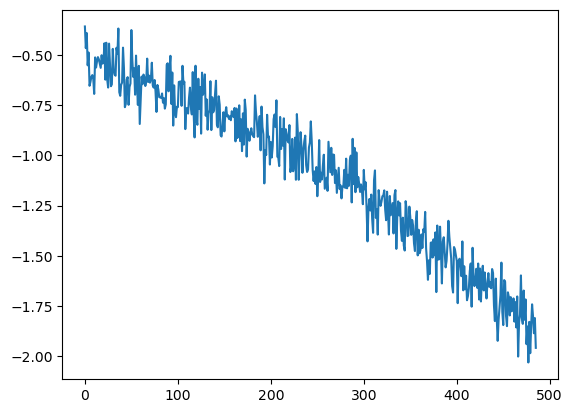

[0.01249645 0.01148795 0.15673388 0.14245748 0.05637274 0.03860642
 0.78298241 0.58062245]
0.0026782973236793234
(-1.9634058068823055+0j)
[0.01249751 0.01150372 0.15670894 0.14265356 0.05635351 0.03865277
 0.78250433 0.58122369]
0.002926170768318565
(-1.780862914832997+0j)
[0.01249711 0.0115198  0.15666635 0.14285662 0.05633078 0.03870303
 0.78198064 0.58188826]
0.003060587362918401
(-1.8531262240074486+0j)
[0.01249424 0.01153457 0.15660897 0.14305899 0.05630017 0.03875182
 0.78143098 0.58259146]
0.002935779539681104
(-1.7751813786949935+0j)
[0.01249342 0.01155037 0.15656504 0.14326238 0.05627568 0.03880138
 0.78090316 0.58325941]
0.0027173124981390183
(-1.9031737896217633+0j)
Epoch 490, Hamiltonian Expectation Value: (-1.9031737896217633+0j)


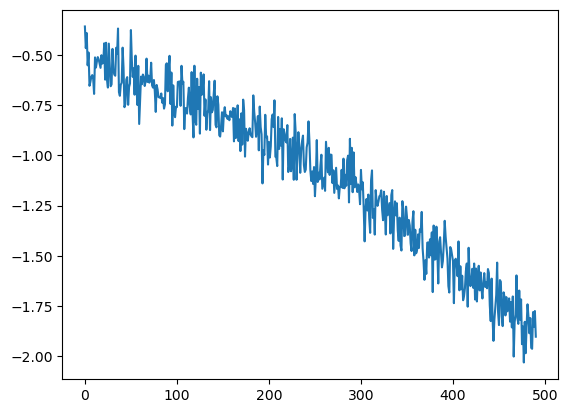

[0.01249356 0.01156568 0.1565326  0.14345697 0.05625418 0.03884748
 0.78041498 0.58387206]
0.002782170939108302
(-1.9959502018010726+0j)
[0.0124923  0.01158026 0.15648909 0.1436486  0.05622928 0.03889348
 0.77991282 0.58450633]
0.0029020704478106467
(-1.937926622045178+0j)
[0.01249219 0.01159653 0.15645018 0.14385348 0.05620651 0.03894319
 0.77939016 0.5851617 ]
0.0030498703571286935
(-1.9461330681147873+0j)
[0.01249054 0.01161231 0.15640366 0.14406475 0.05617745 0.03899244
 0.77883873 0.58585519]
0.0030826185439229523
(-1.8352820160046959+0j)
[0.01248886 0.01162835 0.15634852 0.14427259 0.0561509  0.03904445
 0.77828036 0.58655916]
0.0028297350474062164
(-1.9210963172805966+0j)
Epoch 495, Hamiltonian Expectation Value: (-1.9210963172805966+0j)


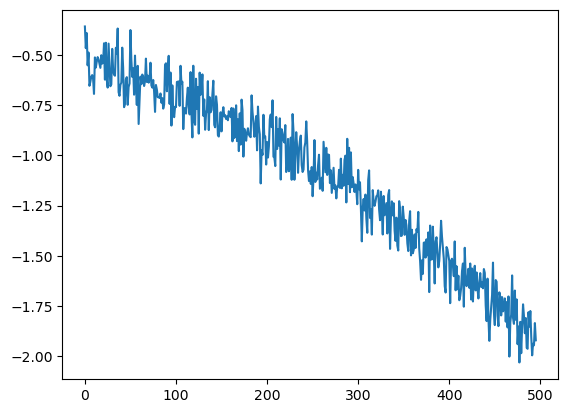

[0.01249081 0.01164593 0.15631654 0.14447748 0.05613599 0.03909728
 0.77777009 0.58719128]
0.002822594681275523
(-1.7907178149073963+0j)
[0.01248988 0.01166123 0.15626422 0.14466701 0.05611498 0.03914735
 0.77725683 0.58783619]
0.002962548702207298
(-1.9292172976286124+0j)
[0.01249099 0.01167886 0.15623611 0.14488624 0.05609295 0.03919853
 0.77671997 0.58849721]
0.002740508573839668
(-2.0313516955100157+0j)
[0.01249052 0.01169406 0.15619391 0.14507732 0.05607129 0.03924602
 0.77622028 0.58911892]
0.002942059356221944
(-1.8057104265784778+0j)


In [4]:
num_epochs = 500
num_gibbs = 1000
lr=0.001

hamil_expects = []

for ii in range(num_epochs): 
    # Compute the gradient update of the RBM
    res_bolt.grad_update(num_gibbs, lr=lr)
    # Using the res_bolt, compute the expectation value of the Hamiltonian
    expect_temp = res_bolt.hamil_expect(num_gibbs)
    hamil_expects.append(np.real(expect_temp))
    # We should expect to see this drop with greater number of epochs
    print(expect_temp)
    if (ii%5==0):
        print(f"Epoch {ii}, Hamiltonian Expectation Value: {expect_temp}")
        plt.plot(np.arange(ii+1), hamil_expects)
        plt.show()
    #input()


## Appendix

In [ ]:
# This implements the contrastive divergence method for updating the Restricted Boltzmann Machine. Some changes will need to be made in order 

def contrastive_div(train_dataset, rbm, epochs=10, lr=0.01, batch_size = 5, verbose=0): 
    num_of_batches = int(len(train_dataset)/batch_size)
    start_time = time.time()
    # Pick visible configurations from the dataset batchwise
    for ii in range(epochs): 
        print("**********")
        print(f"Epoch {ii}")
        # We need to iterate over the training set. For now, we iterate over datapoints, not batches
        for b in range(num_of_batches): 
            v_batch = train_dataset[batch_size*b:batch_size*(b+1)] # the visible neuron configuration from the dataset
            h_stuff_one = [] # the hidden neuron configuration after having done one Gibbs sampling step 
            h_stuff_two = [] # after two Gibbs sampling step
            v_stuff = [] # Sampling the visible neuron config after one Gibbs sampling step. 
            
            for v in v_batch:
                # Get h by performing a Gibbs Sampling step 
                rbm.sample_new_h(v)
                # Store the hidden vector for later 
                h_stuff_one.append(rbm.hid)
                # Get v_temp by performing a Gibbs Sampling step 
                v_temp = rbm.sample_new_v()
                v_stuff.append(v_temp)
                # Using v_temp, sample a new h vector by performing a Gibbs Sampling step 
                rbm.sample_new_h(v_temp)
                h_stuff_two.append(rbm.hid)
            
            # The next step is to compute the updates on the weight parameters
            # grad_update(self, visi_list_0, hid_list_0, visi_list_1, hid_list_1, i,j, lr, expect='weight')
        
            rbm.grad_update(v_batch, np.array(h_stuff_one), np.array(v_stuff), np.array(h_stuff_two), lr)
            
            if(verbose==1):
                print(f"Weights: {rbm.weights} ")
                print(f"Visible Bias: {rbm.bias_visi}")
                print(f"Hidden Bias: {rbm.bias_hid}")
                
                